# HATE SPEECH DETECTION - Sentiment Analysis Project


Viggiano Martina (954603)

## 1. Data import and error removal
Hate speech dataset from a white supremacist forum:  https://github.com/Vicomtech/hate-speech-dataset

In [1]:
import pandas as pd
import numpy as np
import glob
import os
from tqdm import tqdm
import ntpath
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
tqdm.pandas()

C:\Users\marti\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
all_files_paths = glob.glob("hate-speech-dataset/all_files/*.txt")

In [3]:
all_files_paths = [f for f in all_files_paths if os.path.isfile(f)]

In [4]:
all_files_names = [str(ntpath.basename(f)).replace(".txt", "") for f in all_files_paths]

In [5]:
txt_content = {}
errors = []
for name, path in tqdm(list(zip(all_files_names, all_files_paths))):
    with open(path, "r") as txt:
        try:
            txt_content[name] = txt.readline()
        except Exception as ex:
            errors.append((name, str(ex)))

100%|██████████| 10944/10944 [00:01<00:00, 8567.09it/s]


In [6]:
errors

[('13491591_4',
  "'charmap' codec can't decode byte 0x81 in position 23: character maps to <undefined>"),
 ('13493456_1',
  "'charmap' codec can't decode byte 0x81 in position 169: character maps to <undefined>"),
 ('13500400_1',
  "'charmap' codec can't decode byte 0x81 in position 67: character maps to <undefined>"),
 ('13560796_1',
  "'charmap' codec can't decode byte 0x81 in position 5: character maps to <undefined>"),
 ('13572081_1',
  "'charmap' codec can't decode byte 0x81 in position 3: character maps to <undefined>"),
 ('13588794_3',
  "'charmap' codec can't decode byte 0x81 in position 54: character maps to <undefined>"),
 ('13595072_1',
  "'charmap' codec can't decode byte 0x8d in position 75: character maps to <undefined>"),
 ('13595072_5',
  "'charmap' codec can't decode byte 0x8d in position 78: character maps to <undefined>"),
 ('14061724_1',
  "'charmap' codec can't decode byte 0x81 in position 181: character maps to <undefined>"),
 ('14065492_1',
  "'charmap' codec ca

In [7]:
errors_list = [err[0] for err in errors]

In [8]:
df = pd.DataFrame.from_dict(txt_content, orient='index').reset_index()
df.columns = ["file_id", "text"]

In [9]:
df.head()

,file_id,text
0,12834217_1,"As of March 13th , 2014 , the booklet had been..."
1,12834217_10,Thank you in advance. : ) Download the youtube...
2,12834217_2,In order to help increase the booklets downloa...
3,12834217_3,( Simply copy and paste the following text int...
4,12834217_4,Click below for a FREE download of a colorfull...


In [10]:
ann = pd.read_csv('hate-speech-dataset/annotations_metadata.csv')

In [11]:
ann.head()

,file_id,user_id,subforum_id,num_contexts,label
0,12834217_1,572066,1346,0,noHate
1,12834217_2,572066,1346,0,noHate
2,12834217_3,572066,1346,0,noHate
3,12834217_4,572066,1346,0,hate
4,12834217_5,572066,1346,0,noHate


In [12]:
ann = ann[~ann['file_id'].isin(errors_list)]

In [13]:
data = pd.merge(left=ann, right=df, left_on='file_id', right_on='file_id')
data.shape
data.head()

,file_id,user_id,subforum_id,num_contexts,label,text
0,12834217_1,572066,1346,0,noHate,"As of March 13th , 2014 , the booklet had been..."
1,12834217_2,572066,1346,0,noHate,In order to help increase the booklets downloa...
2,12834217_3,572066,1346,0,noHate,( Simply copy and paste the following text int...
3,12834217_4,572066,1346,0,hate,Click below for a FREE download of a colorfull...
4,12834217_5,572066,1346,0,noHate,Click on the `` DOWNLOAD ( 7.42 MB ) '' green ...


In [14]:
data['label'] = data.apply(lambda x: 0 if x['label'] == "noHate" else 1, axis=1)

### 2. Cleaning and tokenization

In [15]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import string
import nltk.sentiment.vader as vd
from nltk import download
download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

#### 2.1 Removing links, tags, numbers and bias

In [16]:
#engl = []
#other = []
#for x in range(len(data['text'])):
#    try:
#        if detect(data['text'][x]) == 'en':
#            engl.append(data['text'][x], detect(data['text'][x])
#        else:
#            other,(data['text'][x], detect(data['text'][x]))
#    except:
#        None

In [17]:
import re
cList = {
    "n't": "not",
    "/TD": " ",
    "pm": "personal message",
    "PM": "personal message",
    "Donot": "do not",
    "MB" : "megabytes"}
c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

In [18]:
data['text']= [expandContractions(x) for x in data['text']]

In [19]:
additional  = ['rt','rts','retweet']
swords = set().union(stopwords.words('english'), additional, string.punctuation)
data['text_clean'] = data['text'].str.lower()\
    .str.replace('(@[a-z0-9]+)\w+',' ')\
    .str.replace(r'http\S+', '')\
    .str.replace(r'www\S+',' ')\
    .str.replace(r'com/watch', ' ')\
    .str.replace(r'\S*[.,:;!?-]\S*[^\s\.,:;!?-]',' ')\
    .str.replace(r' ca ', ' cannot ')\
    .str.replace(r'\w*\d\w*',' ')\
    .str.replace(r'rlm',' ')\
    .str.replace(r'pttm',' ')\
    .str.replace(r'ghlight',' ')\
    .str.replace('[0-9]+(?:st| st|nd| nd|rd| rd|th| th)', '')\
    .str.replace('([^a-z \t])',' ')\
    .str.replace(' +',' ')\
    .apply(lambda x: " ".join([i for i in x.split() if not i in swords]))
#any alpha numeric after @ #http # any value except alpha numeric tab character ('\u0009')
#.str.replace(r'#\S+', ' ')\

In [20]:
data['text'][3156]

"Classic trucker songs YouTube - & #x202a ; Dave Dudley - Diesel Smoke ( 18WoS : PTTM ) & #x202c ; & rlm ; Diesel Smoke another of same song , different video , says the artist was Red Simpson YouTube - & #x202a ; Red Simpson - Diesel smoke , & #x202c ; & rlm ; YouTube - & #x202a ; Red Sovine-Truck Drivin ' Son Of A Gun & #x202c ; & rlm ; Truck Drivin ' Son of a Gun YouTube - & #x202a ; Terry Allen - Amarillo Highway & #x202c ; & rlm ; Amarillo Highway ( slow version , live , with violins ) YouTube - & #x202a ; Robert Earl Keen - Amarillo Highway & #x202c ; & rlm ; Fast rockin ' country version by Robert Earl Keene"

In [21]:
data['text_clean'][3156]

'classic trucker songs youtube dave dudley diesel smoke diesel smoke another song different video says artist red simpson youtube red simpson diesel smoke youtube red drivin son gun truck drivin son gun youtube terry allen amarillo highway amarillo highway slow version live violins youtube robert earl keen amarillo highway fast rockin country version robert earl keene'

In [22]:
data['text'][data['text_clean'].str.contains("#")]

Series([], Name: text, dtype: object)

In [23]:
# Stemming
ps = PorterStemmer()
data['stemmed'] = data['text_clean'].apply(lambda x: " ".join([ps.stem(i) for i in word_tokenize(x)]))

In [24]:
# Lemmatizer
lm = nltk.WordNetLemmatizer()
data['lemmatized'] = data['text_clean'].apply(lambda x: " ".join([lm.lemmatize(i) for i in word_tokenize(x)]))

In [25]:
data['tokens'] = data['lemmatized'].apply(word_tokenize)

In [26]:
from langdetect import detect
languages = []
for x in tqdm(range(len(data['text']))):
    try:
        languages.append(detect(data['text'][x]))
    except:
        None

100%|██████████| 10926/10926 [01:36<00:00, 113.18it/s]


In [27]:
other = []
for x in tqdm(range(len(data['lemmatized']))):
    try:
        if detect(data['lemmatized'][x]) != 'en':
            print(data['lemmatized'][x], detect(data['lemmatized'][x]))
    except:
        None

  0%|          | 26/10926 [00:00<04:00, 45.35it/s]

downloads pl
came across piece garbage ro
comment say sa fr


  0%|          | 43/10926 [00:00<03:38, 49.72it/s]

old tarzan movie zulu king kong many image tl
girl start talking guy middle lip start moving no
believe dog would like get far away possible af


  0%|          | 51/10926 [00:00<03:15, 55.73it/s]

watch hollywood movie en
v entire myron fagan video youtube es
v sk


  1%|          | 57/10926 [00:01<05:05, 35.54it/s]

note it
wntube pl
please contribute donate ro
vid code es


  1%|          | 76/10926 [00:01<04:22, 41.35it/s]

jesus christ lord indeed nl
nice day tr
sooner better no


  1%|          | 98/10926 [00:02<03:30, 51.52it/s]

hard time believing da
hundred people black da
excellent article jail fr


  1%|          | 109/10926 [00:02<03:00, 59.99it/s]

good so
hope starve da


  1%|          | 123/10926 [00:02<03:51, 46.60it/s]

aragorn cy
respond armenian scum stop ro
see giving af
btl tr
apologize ignorance it


  1%|▏         | 145/10926 [00:02<03:22, 53.18it/s]

give example progress made skinhead klan da
seems precipitous decline ca
never drink diet anything either aspartame water fish en


  2%|▏         | 164/10926 [00:03<03:29, 51.44it/s]

pesticide fresh fruit veggie ca


  2%|▏         | 196/10926 [00:03<02:57, 60.34it/s]

pffffft cy
thanks saving picture one saw black guy looking laptop white girl sitting next laughing hanging also looking laptop show laptop tl
jew represents snake en
hell care kosher en


  2%|▏         | 203/10926 [00:03<03:21, 53.18it/s]

concerned zog controlling u russia it
kris roman jan kristel dr alfred vierling dr david duke thiery van roy frederik ranson andreas thierry stephanos gekas af
robert steuckers dr david duke gunther van den eynde en dr david duke nl


  2%|▏         | 218/10926 [00:04<04:06, 43.46it/s]

traitor it
attaboy putin tl


  2%|▏         | 230/10926 [00:04<04:20, 41.06it/s]

keep telling people thing like never believe af
great ro
go work pl
lol es


  2%|▏         | 255/10926 [00:05<03:56, 45.10it/s]

group sweden genuine thief steal money never send good order en
swede hide best looking female af
gl delig jul da
interesting

  2%|▏         | 266/10926 [00:05<04:45, 37.31it/s]

 en
found pretty interesting hope g delig jul no
make damn angry swede can not see af
black brown detroying sweden nobody anything madex madex madex en


  3%|▎         | 276/10926 [00:05<06:10, 28.75it/s]

det er forresten en ting til rkneyjar vil si deg tack mycket no
say jotunheim fi
figure ro
much important estimation fr
denmark assuming population million good job denmark en


  3%|▎         | 287/10926 [00:06<05:20, 33.16it/s]

let see get zero nl
aragorn tl
good news norge cy
possible fr
dare look so
see grandma hair looked like year ago af
jag har inte sj lv varit med n gon g ng men jag har stor respekt f r de som deltar

  3%|▎         | 299/10926 [00:06<04:28, 39.62it/s]

 no
damn finland closing sweden poll sv
suomalainen totta kai fi
reminds old joke et


  3%|▎         | 327/10926 [00:06<02:47, 63.35it/s]

cheer nl


  3%|▎         | 344/10926 [00:06<02:43, 64.75it/s]

looking forward af
regard draiodoir cy
true vi
look jealousy cs
lie lie lie af
love darker hair skin eye no
stunning kiss fi


  3%|▎         | 362/10926 [00:07<02:56, 59.70it/s]

use personal message get touch fr


  4%|▎         | 387/10926 [00:07<02:54, 60.43it/s]

happening school nl
donot ridiculous pt
indeed nl
buying gun bullet tr
fault bnp run gangster no


  4%|▎         | 409/10926 [00:08<03:00, 58.17it/s]

hello friend forum no
sat minute took dog walk af


  4%|▍         | 427/10926 [00:08<03:32, 49.46it/s]

sugar bowl lemon side es
pleasure make acquaintance madam fr
mean ro


  4%|▍         | 434/10926 [00:08<04:50, 36.11it/s]

better hated loved da
rule britannia ro


  4%|▍         | 454/10926 [00:09<04:07, 42.34it/s]

telling kid frankfurt foreigner da
jeeze worst uk pl
girl indeed amazing tr


  4%|▍         | 467/10926 [00:09<04:28, 38.99it/s]

ukraine russia poland romania fake ukrainian et
p someone else csabi according csabi romanian listen hungarian music en
ap ro g ant trois jeunes soup onn de viol fr
start

  4%|▍         | 481/10926 [00:09<03:45, 46.34it/s]

 sv
genius lt
liberia awaits id
tired da


  5%|▍         | 494/10926 [00:10<03:44, 46.43it/s]

hope negro beat negro af
stupid hr
indeed nl
dusty rhodes cy
name past tl


  5%|▍         | 517/10926 [00:10<03:11, 54.39it/s]

last time kissed yesterday et
try link en
use one part fr


  5%|▍         | 532/10926 [00:10<03:21, 51.54it/s]

kalamzoo u odinists town hr
like jager et
neofolk no
email personal message fr
would like talk af
jeremy wpww pl
dallas it


  5%|▌         | 570/10926 [00:11<02:39, 64.96it/s]

worker af
inch dark blonde hazel green eye lb babyface nl
well good cy


  5%|▌         | 590/10926 [00:11<03:27, 49.70it/s]

live san bernardino send personal message da
live san bernardino send personal message ontario mill eh it
like week ago got new doc maybe talk af
like wall idea af


  6%|▌         | 605/10926 [00:12<03:29, 49.30it/s]

next read ro
everyone keep spreading dr duke video around internet soon win war af
would die child

  6%|▌         | 618/10926 [00:12<03:35, 47.84it/s]

 nl
taken dance class various time enjoy fr
problem multiracial environment mean dance ca
eurocentric civ documentary europhobia ro
hahahahahaha

  6%|▌         | 624/10926 [00:12<03:35, 47.89it/s]

 so
kinda place tr
picture sig mennonite farm creston couple mile typing en


  6%|▌         | 638/10926 [00:12<03:49, 44.82it/s]

even someone openly us name en
flyer home symbol look return home get info da
saw poll missippi said think lott step segregationist remark et


  6%|▌         | 656/10926 [00:13<03:45, 45.51it/s]

jew responsible massive immigration europe north america en
justifies policy fr
last paragraph essay talk sticker technique fr
awakening still print id


  6%|▌         | 672/10926 [00:13<03:00, 56.86it/s]

wonder nl
idiot like fail last surrounded pet name alleged savior lip get diversified

  6%|▋         | 691/10926 [00:13<03:26, 49.68it/s]

 no
mention business jail among gang id
exactly want u lay die en
word deed declare staunchly favor genocide people nl


  7%|▋         | 722/10926 [00:14<03:00, 56.65it/s]

tell legalize drug pedophilia it
dear ro


  7%|▋         | 741/10926 [00:14<03:49, 44.39it/s]

upgraded black sv
asian id
light skin dark hair af
native american it
jew enemy good set brain pl


  7%|▋         | 758/10926 [00:15<04:28, 37.87it/s]

nope it
keep civil nl
peanut butter ro
traffic lite ro
link fi
want go back law school pl
pretty simple come come it


  7%|▋         | 776/10926 [00:15<04:12, 40.18it/s]

ya got virgin shooter af
hundred yard cy
paper plate ca
minute et
problem cs


  7%|▋         | 800/10926 [00:16<03:19, 50.66it/s]

youtube id
display id
good shape so
look picture put clear en
working splendidly af


  7%|▋         | 817/10926 [00:16<03:21, 50.11it/s]

stay away alberta so
lol tim it


  8%|▊         | 836/10926 [00:16<03:55, 42.89it/s]

yep tr
anyone ever asked da
say dont care fr
want mixed kid so
hate crime said en
facebook van page nl


  8%|▊         | 847/10926 [00:17<04:58, 33.79it/s]

lot old ambulance rescue van ripe modding live ro
predator xtreme august ro
ever gave hard knock better got no
taken together dark region suggest many shape running man no
yeah hay ride popular tl
gone corn maze well it
good memory cy


  8%|▊         | 858/10926 [00:17<04:15, 39.35it/s]

one fi
watch sw
need get done luck find idf general da
transfer uni

  8%|▊         | 882/10926 [00:17<02:55, 57.23it/s]

 ca
teach alot lie student ro
gone full retard it


  8%|▊         | 892/10926 [00:17<02:33, 65.39it/s]

ever wonder nl
basketball baseball id
pellet flattened quite nicely it


  8%|▊         | 907/10926 [00:18<03:25, 48.85it/s]

even smaller pellet probably ideal buck perhaps no
always partial lully rameau jean baptiste lully l orchestre du roi soleil youtube jean philippe rameau orchestral suite youtube fr
except peanut butter ro


  8%|▊         | 923/10926 [00:18<03:30, 47.44it/s]

like french da
also like renoir sl
man idiot id
yuenglings tl
problem cs


  9%|▊         | 937/10926 [00:18<03:05, 53.92it/s]

kid come get nl
yamaha aerox p youtube yep cc aerox id
thanks encouragement en


  9%|▊         | 944/10926 [00:19<03:26, 48.42it/s]

sister grey eye sister blue eye sister green eye brother blue eye no
hitler mein kampf de
slowly making way romanian bible got birthday july so
gon na suggest old marlin remembered mag en


  9%|▉         | 962/10926 [00:19<03:49, 43.45it/s]

week two one kid asks jewish pl
goy friend cy


  9%|▉         | 979/10926 [00:19<03:01, 54.71it/s]

ghost goblin etc cy
went baofeng website chinese de
saw one palm spring tl


  9%|▉         | 992/10926 [00:20<03:53, 42.63it/s]

surprised see palm canyon drive detail en


  9%|▉         | 1009/10926 [00:20<04:18, 38.29it/s]

great ro
trying dumb u purpose said say working tl
look nonsense tv af
wife post pl


  9%|▉         | 1021/10926 [00:20<04:10, 39.51it/s]

still great liberal experiment continues ca
find inspiring da
bull tr


  9%|▉         | 1033/10926 [00:21<03:54, 42.23it/s]

son ever come home something like bet something say da
cool site it
yeah tr


 10%|▉         | 1043/10926 [00:21<03:50, 42.97it/s]

describe sister es
come pride stay love es
six remember dark

 10%|▉         | 1053/10926 [00:21<03:43, 44.20it/s]

 id
god one claim merciful like nature hr


 10%|▉         | 1075/10926 [00:22<03:24, 48.12it/s]

bet negro planning insanity defense may get no
donot love double standard fr


 10%|█         | 1104/10926 [00:22<03:02, 53.87it/s]

parent like no
wulfi so
feel nl
keep simple et


 10%|█         | 1113/10926 [00:22<02:43, 60.14it/s]

well good hear cy
good so
well im glad hear youth world let hope mudds niggs go cy
knew kid street home schooled didnt act like kid age nl
maybe so


 10%|█         | 1138/10926 [00:23<02:33, 63.83it/s]

freuer frei da
im roxbury pl
god save hr


 11%|█         | 1154/10926 [00:23<03:36, 45.10it/s]

robbie funny problem sk
typical afrikaans music af
seen interview seem trashy af


 11%|█         | 1167/10926 [00:23<03:10, 51.18it/s]

agreed af
absolutely hu


 11%|█         | 1187/10926 [00:24<02:53, 56.20it/s]

nope it
pastor saying truth tl
bean potato yam id
seems nature taking trash et


 11%|█         | 1194/10926 [00:24<03:11, 50.77it/s]

certain cultural practice tell volume people ro
goody run cy
absolute stupidity et


 11%|█         | 1209/10926 [00:24<03:36, 44.79it/s]

beeline tv watch online tv free internet tv live tv channel got number japanese tv link streaming en
lenny pitt article one fr


 11%|█         | 1228/10926 [00:24<03:08, 51.50it/s]

knew report lie entire time fr
make sw


 11%|█▏        | 1244/10926 [00:25<03:01, 53.35it/s]

embarassing id
doubt coming leprechaun chinese flavored uncle sam fr
rumour fr
disgusting negro make u white people look bad en


 12%|█▏        | 1266/10926 [00:25<03:10, 50.82it/s]

make tired hr
cologne seat it
put cursor american dissident voice tab click link menu drop ro


 12%|█▏        | 1292/10926 [00:26<02:41, 59.77it/s]

never ever grocery look like af
even like buying carton juice nl
hate crime video posted pt


 12%|█▏        | 1300/10926 [00:26<02:37, 60.97it/s]

fa pageid cy
notice say kid jew pl
sad happens want take think want date one negro woman af
bid good night cy


 12%|█▏        | 1314/10926 [00:26<03:15, 49.28it/s]

dmitriy hvorostovskiy prince yeletsky queen spade tchaikovsky hvorostovsky metropolitan opera youtube ya va lyublyu dmitri hvorostovsky renee fleming dmitri hvorostovsky perform final scene tchaikovsky yevgeny onegin part youtube yevgeny onegin final scene hvorostovsky fleming renee fleming dmitri hvorostovsky perform final scene tchaikovsky yevgeny onegin part ii youtube yevgeny onegin final scene hvorostovsky fleming ii renee fleming tatiana dmitri hvorostovsky eugene onegin first act aria tchaikovsky opera sk
youtube dmitri hvorostovsky eugene onegin onegin act aria renee fleming dmitri hvorostovsk lippen schweigen lehar die lustige witwe youtube lippen schweigen hvorostovsky fleming offtop bonus hvorostovsky troika youtube hvorostovsky troika dmitri hvorostovsky temnaya noch youtube temnaya noch dmitri hvorostovsky little bell youtube hvorostovsky little bell dmitri hvorostovsky moscow night youtube dmitri hvorostovsky moscow night sk
eye nose skin tone give away af
yes born svrlji

 12%|█▏        | 1333/10926 [00:26<03:19, 48.10it/s]

read million figure million figure estimate million figure compromised it
gon na long post see konavle look better map small land important af


 12%|█▏        | 1354/10926 [00:27<03:07, 50.98it/s]

pray sk
peter drafted army said no
live forum day job da
riga day so
anyone like meet drink love say hello personal message reply no


 13%|█▎        | 1366/10926 [00:27<03:20, 47.70it/s]

picture truly revolting ro
matter dress mud no
mud mud mud et
gypsie woman like black sabbath dont like gypsy af
sympathy cy
yes muslim breed like vermin believe part intention breed race order make majority en


 13%|█▎        | 1372/10926 [00:27<04:46, 33.31it/s]

rensen r er f dt april kolding da
har taget en p handelsskolen nyborg da
medlem af dfu bestyrelse da


 13%|█▎        | 1377/10926 [00:28<06:30, 24.48it/s]

sin fritid g r karina rensen p jagt med sin far dyrker styrketr ning eller nyder tilv relsen med sin k reste no
valgt vejle amt som folketingets yngste medlem nogensinde da
karina rensen er medlem af kontaktudvalget da
karina sorensen member danish people party heritage party en


 13%|█▎        | 1387/10926 [00:28<06:15, 25.41it/s]

rensen year old born april kolding da
member dfu directorate ro
anyway good luck so


 13%|█▎        | 1396/10926 [00:28<05:23, 29.46it/s]

homo tried fag pride parade serbia year ago beaten es
suggesting anything tl
aragorn cy
damn making tag along tl
good night europe af


 13%|█▎        | 1406/10926 [00:28<04:15, 37.24it/s]

susan tl
mistenkt krigsforbrytelser ker asyl norge en tsjetsjener etters kt terrorhandlinger og en libaneser mistenkt ha beg tt krigsforbrytelser bor p asylmottak norge med sine familier no


 13%|█▎        | 1417/10926 [00:29<04:43, 33.49it/s]

myndighetene vurderer n om de skal f permanent oppholdstillatelse da
lebanese one massacre sabra shattila direction israel it
may put away good tl
wolf pl
look like dennys list af
aoh legend de


 13%|█▎        | 1434/10926 [00:29<04:21, 36.24it/s]

likely moving belfast no
send personal message going da


 13%|█▎        | 1441/10926 [00:29<04:26, 35.59it/s]

e u soviet system much worse af
well done cy
time drive traitor sq


 13%|█▎        | 1464/10926 [00:30<03:13, 48.95it/s]

perhaps proud indigenous inhabitant dublin want culture enriching ruining tripe like nl
scum ro
back ya came id
gone find it


 13%|█▎        | 1474/10926 [00:30<02:44, 57.50it/s]

go okay sshh so
wow pl
video etc welcome nl
get lead example ca


 14%|█▎        | 1495/10926 [00:30<02:59, 52.58it/s]

alot work done af
criminal scum ro
wisdom post pl
still prefer native every japanese korean no


 14%|█▍        | 1504/10926 [00:31<03:15, 48.12it/s]

dont see people ignore issue much longer fr
get mine outlet even enemy one nl
good keep track enemy well see saying af


 14%|█▍        | 1517/10926 [00:31<03:29, 44.87it/s]

damn canada so
let get lad da
bad news cy


 14%|█▍        | 1533/10926 [00:31<03:04, 50.97it/s]

wait open door poor people tb capital europe romania ro


 14%|█▍        | 1553/10926 [00:31<02:33, 60.92it/s]

absolute madness et
london f ked da
oh irony cy


 14%|█▍        | 1568/10926 [00:32<03:14, 48.12it/s]

black muslim majority lt
perhaps would like comment link nl
got quote someone it


 15%|█▍        | 1585/10926 [00:32<02:47, 55.74it/s]

saw clip tl
mean warsaw uprising museum id
feel like et
let make clear like muslim still slav brother long keep religion problem no


 15%|█▍        | 1615/10926 [00:33<02:40, 57.85it/s]

groupid fr
got nothing slav slav no
part ethnic group fr
salute bulgaria comrade ro
wonder many mom would kill look good kid af


 15%|█▌        | 1641/10926 [00:33<02:31, 61.41it/s]

let alone fr
beautiful fr
address read enjoy no
link fi


 15%|█▌        | 1656/10926 [00:33<03:07, 49.52it/s]

maybe skip generation da
get ride see time summer cool need get someone nj name hal talk want meet go see stop see ok af
live peoria az it
normal pt


 15%|█▌        | 1670/10926 [00:34<03:03, 50.40it/s]

normal people left ro
hehe de
damn cool so
would like help project nl
u want kick greek u much nationalistic mind u live usa

 15%|█▌        | 1683/10926 [00:34<03:17, 46.83it/s]

 en
hello name sean brennan live mission kansa looking people area hang please email nirvana en
im irish skin id like hear skin nonskin girl around world af
tight referring slogan no


 16%|█▌        | 1696/10926 [00:34<02:59, 51.49it/s]

curious ro
lass fi
mod gone cy


 16%|█▌        | 1722/10926 [00:35<02:37, 58.46it/s]

make sense no
promote nordic superiority it
anyone know tl
ty fi


 16%|█▌        | 1738/10926 [00:35<03:21, 45.51it/s]

rode bus since fr
plan making trip kalispell early august tl
passed devil lake nd flooding en
massive fi
good so
welcome ku klux klan knight party af


 16%|█▌        | 1769/10926 [00:35<02:42, 56.51it/s]

let keep fight one roof keep one fight free af
planet ape no
good so
little troll longer going nip pant leg let look platform no
figure available none made public fr


 16%|█▋        | 1784/10926 [00:36<02:58, 51.18it/s]

yeah surprised id
guess keep et
good point hr


 16%|█▋        | 1802/10926 [00:36<02:52, 52.88it/s]

horny dumb kid sk
philippine tl
jesus christ hr
tf care ro
get nl


 17%|█▋        | 1813/10926 [00:36<03:56, 38.57it/s]

extra concern care tibet ro
look talking et
moron

 17%|█▋        | 1825/10926 [00:37<03:26, 44.06it/s]

 sk
wow pl
hey negro genius cy
swim back jew arm pl
unreal ro
situation it


 17%|█▋        | 1851/10926 [00:37<02:49, 53.41it/s]

wrong cy
also genocide stop calling it
wow pl
putting meet feel free private message

 17%|█▋        | 1867/10926 [00:37<02:44, 54.95it/s]

 no
well wo stand af
visit today

 17%|█▋        | 1878/10926 [00:37<02:28, 60.90it/s]

 fi
try vi
see one et
also available line source ie ke l b fr


 17%|█▋        | 1895/10926 [00:38<02:44, 54.89it/s]

trudeau sneaking like et
could trudeau buddy set fire request fr
hiv aid killing fast enough et


 17%|█▋        | 1902/10926 [00:38<03:01, 49.59it/s]

yes want way sw
enlightening nl


 18%|█▊        | 1915/10926 [00:38<03:31, 42.69it/s]

letter would fall deaf ear en
call government appropriate name it
gotten fatter year no
used bikini model skinny sl


 18%|█▊        | 1926/10926 [00:38<03:16, 45.83it/s]

may want read so
later went get beer opened door yep guessed blood geyser af


 18%|█▊        | 1945/10926 [00:39<03:35, 41.63it/s]

sport no
lying marxist tl
title like teach black kid en
people utter garbage get brain transplant no


 18%|█▊        | 1954/10926 [00:39<04:14, 35.26it/s]

sentiment exactly en
make happen nl
told go said ar around ya lol cy
wo talk anymore wo go church anymore pl


 18%|█▊        | 1964/10926 [00:40<04:06, 36.39it/s]

listening fi
minute gorgeous et
dresden remembrance last year year es
yep tr


 18%|█▊        | 1979/10926 [00:40<03:22, 44.25it/s]

law center prevent gun violence fr


 18%|█▊        | 1985/10926 [00:40<04:57, 30.05it/s]

period basket stamped full top flap holster da
best part fr
lisa grandpa department poker game back id
nobody nobody part basque made w hybrid cy


 18%|█▊        | 1996/10926 [00:40<04:40, 31.88it/s]

mom blue eye dad green eye got eye af
matter quickly dropped fr
love video much sk
seen believe sf thank posting af
seem grasp fact jew stolen german identity first place blend

 18%|█▊        | 2007/10926 [00:41<04:19, 34.33it/s]

 en
haha thinking thing vi
nah man enough tl
like mauricio rua lt
like rony jason fi


 18%|█▊        | 2016/10926 [00:41<04:53, 30.32it/s]

skin color race hope dont come picture blonde jew fr
im giving watching mma good en
ufc tuf rigged staged da
true vi


 19%|█▊        | 2030/10926 [00:41<03:45, 39.51it/s]

younger one say survivor sperm men egg woman en


 19%|█▉        | 2051/10926 [00:42<03:00, 49.26it/s]

unforgivable da
guess jew rabbi guy say must serve jew iraqi jew hr


 19%|█▉        | 2063/10926 [00:42<03:19, 44.35it/s]

fact immoral irresponsible parent influence child immoral irresponsible en
grin bear keep getting respectable grade af
requirement circumcision found nt fr


 19%|█▉        | 2083/10926 [00:42<03:09, 46.64it/s]

truth vi
virtually useless fi
take look blog example no
ha so
like teach negro

 19%|█▉        | 2089/10926 [00:42<03:01, 48.64it/s]

 sl


 19%|█▉        | 2106/10926 [00:43<03:15, 45.15it/s]

problem jew destroyed one else da
usa also ca
youtube id
laughable ca
intended

 19%|█▉        | 2111/10926 [00:43<03:23, 43.24it/s]

 nl
get stafford loan stupid school go refuse student loan turned en


 20%|█▉        | 2132/10926 [00:43<03:15, 44.90it/s]

git happy as tl
iran war time id
solution simple fr


 20%|█▉        | 2145/10926 [00:44<03:05, 47.29it/s]

break no
making really expensive purpose making panic en
please keep mind et
regard kyle sv
liberal care diversity it


 20%|█▉        | 2168/10926 [00:44<02:28, 58.80it/s]

let race continue fr
link fi
check de
jim sw
god cy


 20%|██        | 2190/10926 [00:45<02:50, 51.27it/s]

hell ill even give pic aim p ladieees p aim trilidon ca
ya lazy cant get real job deal drug jump job job job sl
great ro
black wont kid

 20%|██        | 2222/10926 [00:45<02:49, 51.20it/s]

 nl
im grade im hr
havent put logins no
great ro
jew insane literal demonic dna sl


 20%|██        | 2228/10926 [00:45<02:44, 52.99it/s]

feel nl
adrien holboth julia kovacs anita salata dora barkaszi zsofia buki beata frank eszter gulyas eniko halasz ramona kiss marta knoll szandra proksa hu
hungary justice en
never understand pain must felt no


 21%|██        | 2247/10926 [00:46<03:19, 43.46it/s]

lunch surreal en
kid allowed talk so
silence fr
ready go cy
fun es


 21%|██        | 2277/10926 [00:46<02:41, 53.43it/s]

obama declare martial law freedom outpost pt
god rest man soul fr
perhaps get put bnp sticker sv


 21%|██        | 2290/10926 [00:46<02:57, 48.78it/s]

r student negro nl
barely rail cy


 21%|██        | 2301/10926 [00:47<03:21, 42.86it/s]

better head tube en
else da
thorongil get one twin get

 21%|██▏       | 2323/10926 [00:47<02:32, 56.46it/s]

 nl
oh god cy
good so
ai daddy new world order either like jew world order af


 21%|██▏       | 2336/10926 [00:47<02:42, 52.97it/s]

latest attack groid fr
impulsive negro stripping it
made visit word describe racial situation city en
driving near usc darky sv


 22%|██▏       | 2369/10926 [00:48<02:24, 59.34it/s]

ca ro
allegedly grabbed knife home kitchen ended stabbing engelhardt father alan maternal grandmother marlene gacek en
source fr
dont get kid burden white people nl
say love god much like

 22%|██▏       | 2383/10926 [00:48<02:38, 53.75it/s]

 hr
get right af
go figure it
absolutely en
disgusting advertisement ever seen fact disgusting thing seen ever nl


 22%|██▏       | 2395/10926 [00:48<02:51, 49.77it/s]

image melvin wei de
wow beautiful wn like seig heil salute need woman like beautiful indeed af
look like quite picked lot aryan gene af


 22%|██▏       | 2402/10926 [00:49<02:54, 48.90it/s]

aragorn tl
struggle make self da
truth vi
someone tell find cebephibe bpata it


 22%|██▏       | 2432/10926 [00:49<02:35, 54.50it/s]

msciwoj pl
soccer music it
google skill failed da
lycurgus moderation forever let da


 22%|██▏       | 2444/10926 [00:49<03:22, 41.84it/s]

middle ground da
live oslo huge problem sl
sad true es
downfall begun cy


 22%|██▏       | 2456/10926 [00:50<03:04, 45.95it/s]

kiss uncle samael et
look arabic anything tl
aragorn cy
far excelled anatoly karpov garry kasparov sv


 23%|██▎       | 2476/10926 [00:50<02:44, 51.29it/s]

adopting kid answer af
oh wait never happened en
ethnic crime ro


 23%|██▎       | 2482/10926 [00:50<03:37, 38.76it/s]

get nl
refuse believe af
fun way

 23%|██▎       | 2487/10926 [00:50<04:23, 31.99it/s]

 so
aragorn tl
matter time become hell hole like sweden uk da
god bless

 23%|██▎       | 2495/10926 [00:51<04:29, 31.27it/s]

 cy
good news happens european nation doubt pushed like jew like summer redstone mtv af
god bless cy


 23%|██▎       | 2523/10926 [00:51<02:50, 49.43it/s]

islamisation going europe object fr
agreed af
nice pl
bull tr


 23%|██▎       | 2555/10926 [00:51<01:59, 69.94it/s]

eu wonderful af
id cy
sure seen munster fan last weekend af
czynski pl


 23%|██▎       | 2565/10926 [00:52<02:29, 55.96it/s]

visited website facebook page like see af
bad bc so
would meet ya lot work lol af
maaaaany pinders asian tl
sound like sensible well plan no


 24%|██▎       | 2573/10926 [00:52<02:33, 54.25it/s]

dumb dumb dumb fr
government keep track suit vodka first loot kit brood

 24%|██▎       | 2581/10926 [00:52<02:45, 50.49it/s]

 af
went talk georgetown university last week nl
wonder happened nl


 24%|██▍       | 2596/10926 [00:52<03:01, 45.87it/s]

prime miss jean brodie trailer youtube fr
difference it
andr rieu beautiful blue danube youtube fr


 24%|██▍       | 2623/10926 [00:53<02:17, 60.54it/s]

man game every player get together nice cuddle en
kindest regard je sl
usa fi
many tl
indeed nl


 24%|██▍       | 2655/10926 [00:53<01:52, 73.41it/s]

c vi
situation australia canada it


 24%|██▍       | 2663/10926 [00:53<02:33, 53.95it/s]

indian stanis spit street af
disgusting af


 24%|██▍       | 2676/10926 [00:54<02:48, 49.05it/s]

glad realized hr
correct es
changing guard changing negro tl
lol es
npd demonstration hamburg attendant sv
said lv


 25%|██▍       | 2688/10926 [00:54<03:12, 42.82it/s]

demonstranten gegen au dem land kn kieler nachrichten kiel kurd pkk demostration today de
google translate google translate af


 25%|██▍       | 2717/10926 [00:54<02:16, 60.03it/s]

nice picture video ro
wait going people euro af
send u drmradio cy
john fi
vancouver fr


 25%|██▌       | 2739/10926 [00:55<02:08, 63.95it/s]

want female smart look like top model imporant ask deserve af
note self lose wombat af
seen happen nl


 25%|██▌       | 2754/10926 [00:55<02:15, 60.31it/s]

around hungarian anyone tl
get credit nl
place go deep foot nl
guess could fr
alot busier saturday sunday

 25%|██▌       | 2780/10926 [00:55<01:56, 69.81it/s]

 id
buddy boat cy


 26%|██▌       | 2796/10926 [00:56<02:23, 56.62it/s]

go near it
agreeance great place speak vent anger get living zogworld nl
wp wp wp wp pl
race skin color ro
like japanese really et
respect es
sweet af
bb hu
u wan na chat drop line rahowa pl
many wonderful people mention meet soon enough nl
good luck so


 26%|██▌       | 2816/10926 [00:56<02:20, 57.74it/s]

black metal preserving european culture value ro
kc skin boy looking kc skin girl af
draco cy


 26%|██▌       | 2831/10926 [00:57<02:37, 51.30it/s]

go school oregon nl
cheer edward nl
little one adorable en
look like jjt taken lead et


 26%|██▌       | 2847/10926 [00:57<02:19, 57.71it/s]

defend boarder da
mrbadgersir da


 26%|██▌       | 2867/10926 [00:57<02:14, 59.88it/s]

dont doubt saying bnp hope well af
bless mr duke no
medium praise encourage establishment denoucing degrading white man establishment en
persecution

 26%|██▋       | 2882/10926 [00:57<02:30, 53.60it/s]

 ro
able elect mayor soon es
harsh punishment rapist sq
klansman refuse see real problem

 26%|██▋       | 2889/10926 [00:58<03:32, 37.83it/s]

 no
time perplexing ro
good work af
plan going work making money tl


 27%|██▋       | 2899/10926 [00:58<03:20, 39.97it/s]

sent email day last night handed leaflet made david duke talk duke lacrosse case st louis volksfront donated fr
idea page it
jim sw


 27%|██▋       | 2914/10926 [00:58<03:20, 39.87it/s]

calman ca
thank skingirl af


 27%|██▋       | 2927/10926 [00:59<03:09, 42.24it/s]

cf cy
evolve homo sapiens quite contrary retained intelligence spite it


 27%|██▋       | 2948/10926 [00:59<02:22, 56.06it/s]

rotten core it
israel disagrees af
asian smart id


 27%|██▋       | 2967/10926 [00:59<02:01, 65.76it/s]

glad gay so
contradicts statement race dont exist fr
play game day want so


 27%|██▋       | 2984/10926 [00:59<02:06, 62.79it/s]

must met point time fr
guess taste pt
elk hunter no
dr cy
nation desperate need immigration time zero tolerance policy illegally it
think video inappropriate child

 28%|██▊       | 3009/10926 [01:00<02:05, 63.02it/s]

 en
tactical pen ca
else new af
gay late party tl
saying sky blue grass green no


 28%|██▊       | 3035/10926 [01:00<01:55, 68.04it/s]

way so
tnb no
savage mag tl
scope it
anyone wonder white student avoid uc berkeley nl
oh look al qaeda so


 28%|██▊       | 3054/10926 [01:00<01:59, 65.64it/s]

like et
would af
people friend fr
doubt los angeles ce pool es


 28%|██▊       | 3070/10926 [01:01<02:29, 52.43it/s]

hearing wagner end video made want charge night sword af
bookmarked website last night af
went miss state saw jew student nl
got ta represent coconut mango yo ca


 28%|██▊       | 3083/10926 [01:01<03:16, 39.91it/s]

since college suggest working degree plan moving k working new school en
start somewhere talk no


 29%|██▊       | 3115/10926 [01:02<02:09, 60.30it/s]

one hell system designed flood shaft da
saw episode soprano applauding tony tl


 29%|██▊       | 3129/10926 [01:02<02:56, 44.13it/s]

never liked working metal much wood af
steel casing harder gun nl
steel harder brass nl


 29%|██▉       | 3149/10926 [01:02<02:28, 52.27it/s]

pull right push sq
agreed af
worried well af
herp vet gone til middle april can not wait get checked nl


 29%|██▉       | 3168/10926 [01:03<02:46, 46.54it/s]

roll big mamma youtube tl
like legend vigger charlie crack da
go see tube video van af
fedor going like hurt lot no
anything tl


 29%|██▉       | 3192/10926 [01:03<02:27, 52.38it/s]

v vaezznw mjo sl
one talk real problem et


 30%|██▉       | 3233/10926 [01:04<01:44, 73.67it/s]

take little person no
pagan wedding man woman tl
amazing picture ro


 30%|██▉       | 3242/10926 [01:04<01:52, 68.17it/s]

jew demanding worst patient nl
seen happen many time explode en
link document b moore put film ro


 30%|██▉       | 3259/10926 [01:04<02:05, 61.01it/s]

good site sign newsletter af
keep spread word af
love big dog sl


 30%|██▉       | 3267/10926 [01:04<02:08, 59.40it/s]

nice picture ro
david s sv
take care en
seems old proverb dog flea come mind da


 30%|███       | 3292/10926 [01:05<02:05, 60.92it/s]

course dog noble creature fr
allude et
well like said keep et
good luck so


 30%|███       | 3300/10926 [01:05<02:07, 59.87it/s]

make easier form no
im girl year old skin canada tr
put msn dont accept dont want en
judge color hip en
colour ghetto fly super dawg slang en


 30%|███       | 3314/10926 [01:05<02:25, 52.30it/s]

girl bey fly cy
thanks greg en
attack sv
fair enough cy


 31%|███       | 3337/10926 [01:06<02:08, 58.90it/s]

got message trying get across first post felt like messing no
haha so
send message plan come make arrangement meet nl
sixteen jones die antwoord daughter youtube

 31%|███       | 3353/10926 [01:06<02:18, 54.65it/s]

 af
keep hearing wonderful someone even likened christ nl
happening nl


 31%|███       | 3368/10926 [01:06<02:39, 47.47it/s]

zulu final attack youtube ro
rapist technique fr
think video talking earlier make grateful guy keep driving mile mile af
youtube tour detroit ghetto fr
uncalled unwhite uncivilized

 31%|███       | 3374/10926 [01:07<03:38, 34.61it/s]

 it
period it
picture headline detroit crap fr


 31%|███       | 3388/10926 [01:07<02:49, 44.49it/s]

dung stupid able tap market id
story like sad no


 31%|███       | 3402/10926 [01:07<03:05, 40.45it/s]

reading article one get get impression comp sci department desperate grateful body regardless color department en
jack mclamb contacted ca
course fr
nancy grace news week pl


 31%|███▏      | 3427/10926 [01:08<02:44, 45.60it/s]

string em da
bible jewish pl
always take something someone else make no
taken particular test like ten time no
people circle acquaintance bit obsessed iq fr


 31%|███▏      | 3438/10926 [01:08<03:18, 37.77it/s]

pretty sure troll it
take back said report en
interesting guy never seen derren brown nl
got kid got ta pay kid tl
youtube obama going pay gas mortgage tl


 32%|███▏      | 3460/10926 [01:08<02:30, 49.58it/s]

youtube id
crippin nigga tl
crippin nigga tl
cripppinnn it


 32%|███▏      | 3476/10926 [01:09<02:16, 54.65it/s]

going get bad come nl
hydradeck human youtube cy


 32%|███▏      | 3491/10926 [01:09<02:22, 52.19it/s]

imagine uproar black girl said ten ro
youtube id
study ago cy


 32%|███▏      | 3507/10926 [01:09<02:07, 58.39it/s]

tf no
love sl


 32%|███▏      | 3520/10926 [01:09<02:13, 55.56it/s]

azer syria georgia greece ro
mongol england tl
mean look photo dont get feeling nl
edin eko bosnian soccer player zvjezdan misimovi mismovic eko bosnian president zeljko komsic angela lejla damardzic bosnian special force ose bosnian street people sl


 32%|███▏      | 3532/10926 [01:10<02:59, 41.18it/s]

please put picture average people model ro
mate one would asking af
wow pl
slav black darker hair color sv
would like see one time faves en


 33%|███▎      | 3554/10926 [01:10<02:32, 48.50it/s]

keep russia free dark skinned being thank please forgive mistake no
know gypises look like easten europe seen many lviv ukraine begging food no
opendocument ro


 33%|███▎      | 3560/10926 [01:10<02:27, 49.92it/s]

kkk ku klux klan time et
since eleventh letter alphabet k k ku klux klan da
skinhead racial prejudice skinheadsi protiv rasne diskriminacije arpovci debili hr


 33%|███▎      | 3566/10926 [01:10<03:06, 39.41it/s]

restaurant ca
oldest belgrade restaurant built property knez milo obrenovic en


 33%|███▎      | 3582/10926 [01:11<03:15, 37.59it/s]

restaurant skadarlija tri sesira restaurant summer skadarlija id
restaurant summer skadarlija ima dana restaurant id
download enjoy en
aragorn cy
never forget heroism da


 33%|███▎      | 3608/10926 [01:11<02:34, 47.50it/s]

hello fi
swede cy
tell wo happen nl
father sweden watch daughter safety cy


 33%|███▎      | 3622/10926 [01:12<02:41, 45.10it/s]

dream negress sd come riksdag no
gone cy
taking advantage nature far long tl


 33%|███▎      | 3638/10926 [01:12<02:37, 46.19it/s]

ya gota fecken kiddin st patrick black sv
hope sort protest fr
ireland need arab scum like en


 33%|███▎      | 3654/10926 [01:12<02:10, 55.80it/s]

hail cy
expert please explain never drug seizure linked even arrest nl
nobody idolizes ira lv


 34%|███▎      | 3674/10926 [01:13<02:44, 44.12it/s]

id pt n sv
truly sad en
say draiodoir cy
elizabeth sq


 34%|███▍      | 3697/10926 [01:13<02:02, 58.97it/s]

like see video picture et
like new group like wo af


 34%|███▍      | 3711/10926 [01:13<02:10, 55.49it/s]

gon na soon tl
male female ro
simple it


 34%|███▍      | 3743/10926 [01:14<02:03, 57.93it/s]

bad never lower self level self denial blindness da
hello typing see message no
indeed nl


 34%|███▍      | 3750/10926 [01:14<03:04, 38.83it/s]

slag anyone vote bnp nf tl
excuse pt
fact reflect actual essence person could fr
hello fi


 34%|███▍      | 3768/10926 [01:15<02:35, 46.10it/s]

asmodean pt
greeting af
supporting destruction future generation fr
beuthen gro stadt im oberschlesischen kohlenrevier youtube de
dunnes striker attend funeral let hope red mistaken usual white target jungle savage no
anything day two en
id

 35%|███▍      | 3789/10926 [01:15<02:16, 52.47it/s]

 cy
wonder taste come europe couple decade fr
never met london no
jesli sa sie chowaja albo nie wiedza co stormfront pl
nigdy nie spotkalem zadnego w londynie pl
greeting af
must say younger guy sure keep gal young fit en


 35%|███▍      | 3804/10926 [01:15<02:11, 54.20it/s]

eye linger no
said year old cy
im de
kelly hu


 35%|███▍      | 3820/10926 [01:16<02:00, 58.83it/s]

clue lol es
anyways wan na party respond en


 35%|███▌      | 3827/10926 [01:16<02:34, 45.86it/s]

hundred skin esp area da
sent ya personal message id
check local regional post it
gott mit un de


 35%|███▌      | 3844/10926 [01:16<03:00, 39.26it/s]

going tl
skin hr
ca ro
looking pen pal would like hear u af
wolf pl
anybody new york cy


 35%|███▌      | 3850/10926 [01:16<03:05, 38.19it/s]

sean gillespie attack it
cool dude fr
right want lil rotweiler het one name schatzi aww cause sweetie val love smiley nl


 35%|███▌      | 3859/10926 [01:17<03:50, 30.64it/s]

driving virtual adventure no
youtube kalispell one favorite city it
butte montana promotional video youtube it
guess everyone glacier weekend nl
long day beautiful course fr
getting someone else dirty work got u mess today af


 35%|███▌      | 3871/10926 [01:17<03:12, 36.74it/s]

decided take debate personal message ca
check personal message it
robert sk
perhaps retire

 36%|███▌      | 3886/10926 [01:17<02:49, 41.45it/s]

 ca
kind say coming tl
congrats

 36%|███▌      | 3903/10926 [01:17<02:19, 50.29it/s]

 ca
comment spot target fr
absolutely en
hoodies sweetshirts woman t men t af


 36%|███▌      | 3918/10926 [01:18<02:23, 48.73it/s]

crime particular problem live ro
stay away fast food garbage so
let pollute body garbage da


 36%|███▌      | 3943/10926 [01:18<01:53, 61.63it/s]

maybe so
vouch cs
working af
w event id nl


 36%|███▌      | 3959/10926 [01:18<01:46, 65.29it/s]

big talk none ball tell skin face no
skin wore suit rally af
asked da
like idea et
never smile da
talk like gangster yo yo yo

 36%|███▋      | 3981/10926 [01:19<02:00, 57.53it/s]

 tr
smoke skinny cigar sv
avoid fi
never seen asian woman dating asian like white man wiggers detrimental towards af
seen happen many time site lurking day id


 37%|███▋      | 3996/10926 [01:19<02:09, 53.59it/s]

disgusting af
hi sw
welfare cy
dont move nebraska sl
minnesota fi


 37%|███▋      | 4015/10926 [01:19<02:06, 54.48it/s]

deal es
sexual reference ca
like groomed af


 37%|███▋      | 4031/10926 [01:20<02:33, 44.95it/s]

v index list de


 37%|███▋      | 4051/10926 [01:20<02:19, 49.14it/s]

never sl
v deiw v v v wtnfdpxtfek sk
man got listen pas nl
get trouble speaking no


 37%|███▋      | 4069/10926 [01:21<02:19, 49.12it/s]

alien de
look degree much used nl


 37%|███▋      | 4079/10926 [01:21<02:39, 42.97it/s]

vital fi
total disgrace dollar go promoting degenerate filth it
expect homosexual muslim mayor es
say dont want take gun tl
say want mile apart tl
oh fi
easier explain fr


 38%|███▊      | 4104/10926 [01:21<02:05, 54.17it/s]

anything like market today no
op faggot da
hardly slav great great grandma serbian little slavic no


 38%|███▊      | 4120/10926 [01:21<02:01, 56.21it/s]

suggestion get da
make suck jew run black play hr
warning lot naked skin boob hope forgive

 38%|███▊      | 4132/10926 [01:22<02:37, 43.09it/s]

 en
never fell hump back day en
year ago cy
run three mile day week day hike rifle alice gear weekend

 38%|███▊      | 4144/10926 [01:22<02:31, 44.68it/s]

 en
yup id


 38%|███▊      | 4154/10926 [01:22<03:14, 34.78it/s]

stay gel test af
fantastic idea it
support it
gay dude so
disagree af


 38%|███▊      | 4181/10926 [01:23<02:16, 49.58it/s]

got deserved da
imagine got percent negro it


 38%|███▊      | 4205/10926 [01:23<02:05, 53.70it/s]

never seen poster af
like selecting movie en
movie sk


 39%|███▊      | 4223/10926 [01:24<02:17, 48.73it/s]

like said rule change would destroy sport af
striking even dominated grappling rule minimal let alone no
ignorance sport pretty striking no
hope compete pt
evangel n af
going play black sheep say nothing wrong tl


 39%|███▉      | 4237/10926 [01:24<02:00, 55.65it/s]

mechanism death question along remembrance people die fr
miss dr pierce much fr
music lesson fr


 39%|███▉      | 4243/10926 [01:24<02:59, 37.27it/s]

lord fredrik leighton no
monster no
compulsatory education school special pleader suspense girl dog la pensierosa es
marie spartali stillman

 39%|███▉      | 4263/10926 [01:25<02:34, 43.24it/s]

 it
mary gow pl
lady dream cy
calmady child cy


 39%|███▉      | 4269/10926 [01:25<02:28, 44.76it/s]

maybe different cy
one nice doll it


 39%|███▉      | 4290/10926 [01:25<02:07, 52.23it/s]

youtube barbie doll test fr
bump id


 39%|███▉      | 4306/10926 [01:25<01:55, 57.21it/s]

explain garbage son fr
comment appreciated it
like wiggers af


 40%|███▉      | 4319/10926 [01:26<02:20, 47.13it/s]

dress like black talk ike act stupid no
thing go get skin dyed en
sad time et


 40%|███▉      | 4343/10926 [01:26<01:55, 57.08it/s]

voted likely take world first kill af
never ever gotten first base no
better five buck hour da


 40%|███▉      | 4356/10926 [01:26<02:06, 51.77it/s]

look like black lost even one lol diablo et
wan na look like skinny white lady black beautiful shake head en
maybe similar tl
peter great no


 40%|████      | 4374/10926 [01:27<02:13, 48.97it/s]

lived union truckstop truckstop milliken avenue exit sv
drink beer relaxe good luck af


 40%|████      | 4380/10926 [01:27<02:15, 48.44it/s]

school begin week answering question nl
well done cy
disgusting perverted

 40%|████      | 4398/10926 [01:27<02:18, 47.00it/s]

 af
asset fi
true good point hr


 40%|████      | 4418/10926 [01:28<01:56, 55.74it/s]

putting u debt id
go post soon possible fr
none video play es
seem fake window trying get go hook site af


 41%|████      | 4431/10926 [01:28<02:04, 52.19it/s]

god bless cy
good video af
deserve as kicking en
ple sayanim tl
wiki sw


 41%|████      | 4443/10926 [01:28<02:48, 38.37it/s]

close finnic estonian ro
since die stem racist ro


 41%|████      | 4455/10926 [01:29<03:02, 35.55it/s]

saved site no
get vomit bag nl
oh ing god cy


 41%|████      | 4477/10926 [01:29<02:10, 49.52it/s]

negro cy
sure negro coming it
youtube euclid square mall dead mall anyone report euclid ohio ca
yah guess id


 41%|████▏     | 4514/10926 [01:29<01:28, 72.22it/s]

black send back sv
wonder one victim opened door apartment reason en
open door anyone nl


 41%|████▏     | 4529/10926 [01:30<01:50, 57.70it/s]

assuming skinhead tattoo kill people fun et
ha ha true vi
yo crap es
sound like intelligent person say need remove race message message da
cant protest fr
youtube id


 42%|████▏     | 4543/10926 [01:30<01:53, 56.30it/s]

send afreaka sink farkin boat da
bernard goetz need af
uk july fi


 42%|████▏     | 4556/10926 [01:30<02:17, 46.44it/s]

los angeles gone es
yes saw tl
uncomfortable es
like god telling u work af


 42%|████▏     | 4571/10926 [01:31<01:54, 55.33it/s]

week grocery look like around world fstoppers af
himmler bundesarchiv june de
yes tr
sometimes european look alike af


 42%|████▏     | 4585/10926 [01:31<01:45, 60.08it/s]

likewise af
il kidnap sl
cia fsb team ca


 42%|████▏     | 4598/10926 [01:31<02:11, 48.11it/s]

need feel skin next time wont give land subhuman muslim dog en
good see back public display kremlin hr
saying see tl


 42%|████▏     | 4609/10926 [01:31<02:19, 45.13it/s]

hate drama bull like tr
ukraine matter fi


 42%|████▏     | 4628/10926 [01:32<02:38, 39.79it/s]

bloody hell kondor rnu excellent mate no
appreciate it
lot pic godunov anyone ever care see ca
muahaha id
palatka fla id


 43%|████▎     | 4644/10926 [01:32<02:20, 44.66it/s]

getting heart matter work well af
hope line discussion die time it


 43%|████▎     | 4669/10926 [01:33<01:55, 54.37it/s]

shore sq
good day so
seen young latvian girl prague airport dark arab little girl dark id
get unreserved total support no
hail new king norway tl


 43%|████▎     | 4702/10926 [01:33<01:57, 52.82it/s]

massive fan skrewdriver like song da
sure guy red like song no


 43%|████▎     | 4722/10926 [01:34<01:55, 53.58it/s]

come support it
like blowing old lady little kid no
went old friend day drink af


 43%|████▎     | 4730/10926 [01:34<01:44, 59.08it/s]

yeah tr
meineehre heisst treue treue und ehre bi zum tod niemals aufgeben niemals reue da haben wir un einst geschworn class song de
maybe opened eye see en
still snooping eh tl
accident

 43%|████▎     | 4743/10926 [01:34<02:13, 46.43it/s]

 es
nonsense af
rosanna davison think name fi


 44%|████▎     | 4755/10926 [01:34<02:04, 49.46it/s]

ugly hag so
bye no
dave live frigin brampton

 44%|████▎     | 4766/10926 [01:35<02:41, 38.20it/s]

 da
would like see white people get together get u white pride day en
hello joined fi
told immigrant like go home af
knew girl school went one en


 44%|████▎     | 4779/10926 [01:35<02:24, 42.41it/s]

last week af
fantastic it
week ago af
gross af


 44%|████▍     | 4814/10926 [01:35<01:29, 68.12it/s]

thats baz rutten ken shamrock started ufc sv
hd download gb read episode cy
muslim sikh et
cultural threat ro


 44%|████▍     | 4829/10926 [01:36<01:45, 57.94it/s]

marxist america ca
running giving mud no
call lost cause call home it


 44%|████▍     | 4855/10926 [01:36<01:38, 61.70it/s]

related slav no
wow pl
live bad da
tell u it
karl tr
small dog like maltese thing call stoep kakkers good leaving turd stoop af
welcome greatest site meet like minded white folk like world af


 45%|████▍     | 4868/10926 [01:36<02:13, 45.22it/s]

wpww sw
sure someone come along it
patience virtue know fr
control medium it
wonder nl
good luck so


 45%|████▍     | 4883/10926 [01:37<01:49, 55.19it/s]

blut und ehre de
chris de
liquor store le half mile radius one stop selling beer midnight af
lol es


 45%|████▍     | 4907/10926 [01:37<02:20, 42.83it/s]

love speak sl
got personal message strange no
work way af
camie es
met cute florida girl logan pas today es


 45%|████▌     | 4919/10926 [01:37<02:12, 45.33it/s]

decided go road trip es
agreed af
nice pl


 45%|████▌     | 4932/10926 [01:38<01:59, 50.35it/s]

ouuuuuuu hate fi
hi age sw


 45%|████▌     | 4949/10926 [01:38<01:41, 59.01it/s]

done it
great work mjodr af


 45%|████▌     | 4963/10926 [01:38<01:48, 55.12it/s]

hard american get sa nl
never visa left continental usa it
owner bar dont even look bartender place bar nl
subtle message et
click enlarge save desktop use cb punet cbr punet can not punet made day ago using craig list europe

 46%|████▌     | 4982/10926 [01:38<01:49, 54.40it/s]

 fr
glad planning getting sv
people must eat stupid pill like candy et
arkan usa id
great

 46%|████▌     | 4994/10926 [01:39<02:04, 47.77it/s]

 ro
judge moore spoke constitution party event st louis drew people en
suggestion distribution collection fr
zip one big file share gnotella new movie it


 46%|████▌     | 5022/10926 [01:39<01:50, 53.28it/s]

quick fr
pop quiz pt
ready go cy
hate term black reference niggardly kind da


 46%|████▌     | 5035/10926 [01:40<02:17, 42.72it/s]

arenot u tired ur propaganda sv
mr cy
different manipulating jew id
lying tl


 46%|████▌     | 5051/10926 [01:40<01:51, 52.59it/s]

flint violent no


 46%|████▋     | 5067/10926 [01:40<01:43, 56.80it/s]

gee son obama matter sv
see af
unless conscience fr


 47%|████▋     | 5090/10926 [01:40<01:33, 62.20it/s]

youtube sa survival secret pt youtube sa survival secret pt youtube sa survival secret pt youtube sa survival secret pt youtube sa survival secret pt youtube sa survival secret pt fr
greeting af
next week thanksgiving af


 47%|████▋     | 5097/10926 [01:41<01:42, 56.69it/s]

still seeing pumpkin et
scum traitor ro
said like et
great job guy

 47%|████▋     | 5110/10926 [01:41<02:00, 48.39it/s]

 no
hope help nl
yep junk fi


 47%|████▋     | 5123/10926 [01:41<02:27, 39.37it/s]

post sl
wonder one guy jew nl
graduate school seems like good place meet marry man intelligent obviously nl
german men sound sexy sv


 47%|████▋     | 5138/10926 [01:42<02:49, 34.11it/s]

oh song sv
hook nose af
enemy germany inside border time da
well welcome move ever nl
picture truly beautiful ro
speak soul race cs


 47%|████▋     | 5147/10926 [01:42<03:19, 28.96it/s]

youtube ukraine lt
would nice en
didnot get government memo nl
even black pakistani somehow diverse sv


 47%|████▋     | 5161/10926 [01:42<02:29, 38.50it/s]

suggesting appreciate it
mam dad side irish so
kid get candy good bowl cy
even mention jest nl


 47%|████▋     | 5172/10926 [01:43<02:27, 39.02it/s]

form letter send german government behalf ernst zundel da
help keep case alive nl
would want die go heaven germany af
like made good money et


 48%|████▊     | 5198/10926 [01:43<01:51, 51.39it/s]

made sweet potato pie it
awesome af
please keep u updated result get et
download pdf free en


 48%|████▊     | 5209/10926 [01:43<02:14, 42.61it/s]

fmj full metal jacket bullet sv
day age possible fr
german japanese italianos id
peeper getting old no


 48%|████▊     | 5219/10926 [01:44<02:26, 38.94it/s]

hard find video version song youtube delete da
let try no
kettledrummer elo sambo prussian life guard hussar no
suggestion da


 48%|████▊     | 5228/10926 [01:44<03:06, 30.63it/s]

video demonstrating handle front tire da
slam brake hr
youtube id
meat potato bread rice en


 48%|████▊     | 5239/10926 [01:44<02:33, 37.14it/s]

part expensive exclusive fr
ammo expensive pt
list go fr
also get rig pretty darn cheap day en
wont last jump nl


 48%|████▊     | 5257/10926 [01:45<02:26, 38.62it/s]

opinion lt
would love ancient greek pagan name en
good time get af


 48%|████▊     | 5262/10926 [01:45<02:47, 33.73it/s]

get armor da
get armor every member family da
get ballistic helmet nl


 48%|████▊     | 5266/10926 [01:45<03:38, 25.85it/s]

get gas mask lv
get armor kid da
get armor dog da
buy regret bill like ever pass no


 48%|████▊     | 5284/10926 [01:46<02:46, 33.82it/s]

border fence border fence da
good crow duck squirell rabbit etecerta fr
living well best revenge

 48%|████▊     | 5294/10926 [01:46<02:36, 36.07it/s]

 nl
yet black get friend jump da
youtube david irving part

 49%|████▊     | 5311/10926 [01:46<02:14, 41.61it/s]

 en
practice use lr learn ro
purchase rifle pistol en
wp pl


 49%|████▉     | 5335/10926 [01:47<02:11, 42.65it/s]

never lesson fr
funny cy
dragonball z hairstyle rage amongst yr old boy cy
concerned japanese culture insinuating american culture ro
doubt ask clerk no


 49%|████▉     | 5354/10926 [01:47<02:15, 41.04it/s]

year going dog two friend going ghost mail man en
vox romantic it
like many sw
greatest movement romantic join fr
hello rome it


 49%|████▉     | 5365/10926 [01:47<02:04, 44.57it/s]

post back cs
go defending jew nl
ok get dont like talk bad jew btw said kapo af


 49%|████▉     | 5380/10926 [01:48<02:13, 41.51it/s]

much doubt anybody else ask hardly anybody else go like cs
treatment ethnic german east west german surrender real genocide one want talk en
hope go well cy
good so


 49%|████▉     | 5407/10926 [01:48<01:47, 51.26it/s]

ah old day so
sure result discrimination it
type museum zoo need museum animal nature et


 50%|████▉     | 5437/10926 [01:49<01:29, 61.60it/s]

good find cy
black strong sv
also left comment need wait see get approved nl


 50%|████▉     | 5444/10926 [01:49<01:38, 55.67it/s]

comment quite favorable fiercely favorable fr
negative it
honest long overdue no
like see iran wipe israel map af


 50%|████▉     | 5458/10926 [01:49<01:57, 46.47it/s]

would gook want look white af
proud race admire u want proud fr
kimora lee simmons fi
visit used book store riverside af
check stack pl


 50%|█████     | 5469/10926 [01:49<02:14, 40.60it/s]

also national alliance local area contact riverside can not it
college claremont calif it
college va it
hillsdale college hillsdale mich it


 50%|█████     | 5501/10926 [01:50<01:45, 51.25it/s]

thomas aquinas college santa paula calif es
congratulation decision it
good good friend cy


 51%|█████     | 5526/10926 [01:50<01:30, 59.57it/s]

well skin san diego however glad see back af
peter great no
enjoy classical music ca
peter great no


 51%|█████     | 5533/10926 [01:51<01:31, 58.74it/s]

ya hey der so
seen initial fi


 51%|█████     | 5546/10926 [01:51<02:01, 44.36it/s]

so sv
jesus even said face son satan fr
yes tr
seen price beef nl
nice day pl
zdrowie pl


 51%|█████     | 5562/10926 [01:51<01:40, 53.33it/s]

booklet updated dec nl
downloads pl
becs let napj vide nagyon tuti mindig amikor n zek felv teleket vagy ismer seim bar taim me lik hihetetlen sajn lom h tan v pont gy esik h nem tudok ott lenni hu
u dollar please

 51%|█████     | 5578/10926 [01:51<01:30, 59.13it/s]

 es
got wrong cy
yeah de moines fr
one fi


 51%|█████     | 5587/10926 [01:52<01:41, 52.80it/s]

let ask stop federal reserve grab book long no
wow hope negro race pl


 51%|█████     | 5598/10926 [01:52<02:11, 40.52it/s]

hope god blesses da
patrioticmama it


 51%|█████▏    | 5608/10926 [01:52<02:28, 35.89it/s]

protesting funeral no
saying south africa die kop dom moet die lyf sukkel af
feel sorry little sister maybe saved becoming wigger look older sister example da
seems like jewtube hour af
update message cst

 51%|█████▏    | 5619/10926 [01:53<02:25, 36.56it/s]

 fr
japan reactor rod melt ro
japan reactor rod melt ro


 52%|█████▏    | 5631/10926 [01:53<02:04, 42.46it/s]

idea accurate description could happen fr
know say tl
probably cs


 52%|█████▏    | 5643/10926 [01:53<02:04, 42.54it/s]

yawn sw
doesnt even look right af
get used looking like looked obviously fake af


 52%|█████▏    | 5656/10926 [01:53<02:02, 42.88it/s]

came nonsense posting part it
see symbol ware af
added treblinka carlo mattogno extermination camp transit camp it


 52%|█████▏    | 5677/10926 [01:54<01:43, 50.52it/s]

mitt fi
pure ro
school system broken nl


 52%|█████▏    | 5683/10926 [01:54<02:02, 42.72it/s]

youtube detroit gang battle funeral no
never date outside race someone site post fr
noble effort no


 52%|█████▏    | 5707/10926 [01:55<02:28, 35.19it/s]

wonder gobi nl
two element comment quite baffling fr
advocate n simultaneously declare core defining principle blasphemy ro


 52%|█████▏    | 5722/10926 [01:55<02:14, 38.75it/s]

gon na see hell like af
nra may longer exist tl
ukraine need rid jewish oligarch en
youtube kolovrat kosovski front lrm sl


 53%|█████▎    | 5741/10926 [01:55<01:49, 47.21it/s]

pallada photo san francisco bay es
untrue ro
sign time da
ukrainian lt
alba so


 53%|█████▎    | 5755/10926 [01:56<01:37, 52.80it/s]

good idea release video et
refusing register sex offender molesting year old girl da
get dog track say da


 53%|█████▎    | 5772/10926 [01:56<01:51, 46.22it/s]

croat fortunate reliable ally en
barbarian id
leaf surprise fr
kill fast would kill enemy da


 53%|█████▎    | 5787/10926 [01:56<01:31, 56.43it/s]

braun lv
style posting unique unappreciated fr
young man tl
tch tch tch vi


 53%|█████▎    | 5800/10926 [01:56<01:42, 49.87it/s]

wolf pl
hups sw


 53%|█████▎    | 5822/10926 [01:57<01:24, 60.32it/s]

mean muddy bay cy
sure fr
sick de


 53%|█████▎    | 5835/10926 [01:57<01:35, 53.44it/s]

wonder let keep extra euro say unwaged nl
correct es
meh id


 54%|█████▎    | 5855/10926 [01:57<01:39, 50.86it/s]

mr correct es
enjoy sq
would like hear af
damn fine job sure fr
israel arrest bet lentin co student looking see scum jew nl


 54%|█████▍    | 5879/10926 [01:58<01:23, 60.60it/s]

mean ro
agree af
anyone go last night tl


 54%|█████▍    | 5897/10926 [01:58<01:14, 67.42it/s]

looking website sell deliver flag ireland da
anyone ireland got flag please say got want en
uh oh bad move mr king sl
aragorn cy


 54%|█████▍    | 5920/10926 [01:58<01:17, 65.00it/s]

look like jew good broken car garage laugh saw af
anyone back zoo lately hu
sad true es
double standard fr


 54%|█████▍    | 5934/10926 [01:59<01:35, 52.48it/s]

even close es
stopped looked like wtf af
gift keep giving da
n government view dangerous people would decide worthy unworthy would make king maker decide nl
parent need go home get one nl
text table going destroy culture implement communist state

 54%|█████▍    | 5951/10926 [01:59<01:18, 63.10it/s]

 fr
got ta travel light governor en


 55%|█████▍    | 5964/10926 [01:59<01:46, 46.65it/s]

lurker grandson royal marine green beret stormed normandy served pacific da
scumbag swine churchill en
roosevelt deserve die thousand death nl
saying tl
manslaughter nl


 55%|█████▍    | 5976/10926 [02:00<01:55, 42.70it/s]

mate id
cheer nl
men saying id
multiple gang tl
bang tl


 55%|█████▍    | 5985/10926 [02:00<01:40, 49.36it/s]

hello fi
someone kindly tell enter signature no


 55%|█████▍    | 6005/10926 [02:00<02:11, 37.43it/s]

imagine someone tell fault provoked russian similar idiotic bullcrap it
ukrainian sign pact devil get rid putinistan aka russian federation id
plan new sf europe en
youtube

 55%|█████▌    | 6019/10926 [02:01<01:46, 45.96it/s]

 id
ugh so
god willing cy
full name saylum tr


 55%|█████▌    | 6032/10926 [02:01<01:47, 45.57it/s]

dragging blanket around went closet get warm sweater af
yeah tr
haha doze gangstaas kno sheeeeiit bout pimpin tl
got ta surprise else get away af


 55%|█████▌    | 6043/10926 [02:01<02:07, 38.17it/s]

work af
pic taken summer fi
eeeeh great summer nl
friend mar nice cat ro
pawel cy
lazy want digg two graf fallen soldier af


 55%|█████▌    | 6048/10926 [02:01<02:34, 31.65it/s]

brutal war so
look like everyone got haircut door except friend af
sign like passop danger da
badly spelt like everything else holland no
comment fr


 56%|█████▌    | 6069/10926 [02:02<01:55, 41.88it/s]

guess must forgotten engles lack use try espagnol fr
later paid byjiffylube car good new cy
live stevens point fr


 56%|█████▌    | 6084/10926 [02:02<01:32, 52.28it/s]

wan na talk im personal message id
hey hows live georgia wan na talk like talk maybe ill see powderly ky nordicfest af
single live elizabeth nj sq


 56%|█████▌    | 6097/10926 [02:02<01:49, 44.20it/s]

want meet single girl alberta idea want meet old let know nl
tereasa en
may god goddess watch cy
wonder list hate jew nl


 56%|█████▌    | 6113/10926 [02:03<01:28, 54.36it/s]

see af
la es


 56%|█████▌    | 6126/10926 [02:03<01:59, 40.30it/s]

eric de
event would made great tv en
america hate crime law en


 56%|█████▌    | 6137/10926 [02:03<02:02, 39.02it/s]

sometimes person dye hair black look strange en
dark hair dyed hair black looked odd cy
ask away redneck pl
saw post day ago tl
place look job

 56%|█████▋    | 6155/10926 [02:04<01:48, 43.79it/s]

 sl
utah id
example local economy employment opportunity en
call it
fsicqgo agw cy


 56%|█████▋    | 6162/10926 [02:04<01:41, 47.14it/s]

time sq
wonder jackhammer vault foundation nl
last one night durn tired format jpeg pdf get flyering da


 56%|█████▋    | 6173/10926 [02:04<02:06, 37.65it/s]

cf cy
give taste medicience it
actually u killing killing u fi
way say hi so


 57%|█████▋    | 6194/10926 [02:05<01:53, 41.66it/s]

like pas paper nationalist time looking tl
check web site de
best paper movement no
sound like paradise

 57%|█████▋    | 6208/10926 [02:05<01:37, 48.18it/s]

 no
sad so
african anyway cy


 57%|█████▋    | 6215/10926 [02:05<01:29, 52.43it/s]

understand post depressing en
trolling venting no
problem black pride

 57%|█████▋    | 6226/10926 [02:05<02:23, 32.70it/s]

 da
even support no


 57%|█████▋    | 6246/10926 [02:06<01:41, 46.07it/s]

fbi da
discus ro


 57%|█████▋    | 6253/10926 [02:06<01:58, 39.58it/s]

get nl
ant tl


 57%|█████▋    | 6264/10926 [02:06<01:58, 39.41it/s]

ant create civilization monarchy en
like wolf fight die af
see ripped guy like wonder sexy type woman would go internet warrior nerd like af
completely disgusting continue house people complete contempt u law custom en
check

 57%|█████▋    | 6274/10926 [02:07<02:02, 37.91it/s]

 de
deadly cy
n tl
let see say fi
moment situation dire it
crazy pl
keep eye open time fallen powerlines

 58%|█████▊    | 6291/10926 [02:07<01:36, 47.90it/s]

 nl
seen game store nl


 58%|█████▊    | 6304/10926 [02:07<01:34, 48.75it/s]

well done cy
sub compact xdm ro
get hand get one fit nl
yes kkk canada invited get tr
like keep cop af


 58%|█████▊    | 6325/10926 [02:07<01:39, 46.28it/s]

simple lack judgement caused fr
sad so
disgusting justin want live af
disturbing muslim refugee video ever see buzzpo af


 58%|█████▊    | 6337/10926 [02:08<01:51, 41.17it/s]

least people u gun defend ro
started reading mein kampf en
canada big so


 58%|█████▊    | 6342/10926 [02:08<02:04, 36.84it/s]

still bottle cage bike da
put sport drink longer ride keep water camelback en


 58%|█████▊    | 6347/10926 [02:08<02:21, 32.26it/s]

cindy pl
walked right af


 58%|█████▊    | 6358/10926 [02:09<02:37, 28.93it/s]

going get time da
kick piece pl
ask friend da
plan youtube tl
oh better believe da
black sv


 58%|█████▊    | 6369/10926 [02:09<02:23, 31.86it/s]

im gon na see get kobo damn nope af
norman conquest es
send u email

 58%|█████▊    | 6374/10926 [02:09<02:08, 35.52it/s]

 fr
defend de
look good so
love audio

 59%|█████▊    | 6395/10926 [02:09<01:37, 46.29it/s]

 fr
evidence es


 59%|█████▊    | 6401/10926 [02:10<02:14, 33.76it/s]

v clav neck karel dr marta kubi ov dary nesem youtube sl
somebody know sk
gun show year so
young gun show tl


 59%|█████▉    | 6421/10926 [02:10<01:49, 41.06it/s]

black need black pas gene sv
let see find da
okay enjoy toast fi
yeh yay so


 59%|█████▉    | 6435/10926 [02:10<01:51, 40.37it/s]

age old start driving truck long haul en
special spring snack kes en
smell gone matter second it
x x so
solution walkie talkie take double battery af


 59%|█████▉    | 6471/10926 [02:11<01:14, 59.51it/s]

looked like inch tall saw et
many master desire ca


 59%|█████▉    | 6485/10926 [02:11<01:34, 46.89it/s]

dare give u evidence crime tape it
video like make go hmm sl
brass super blackhawk dragoon grip frame sv
best cap ball revolver ever made

 59%|█████▉    | 6496/10926 [02:12<01:47, 41.24it/s]

 no
period it
rifle cy
best round mean grain pyrodex pellet grain fffg cap get job done fr
need new stock ramrod nipple en


 60%|█████▉    | 6517/10926 [02:12<01:23, 52.55it/s]

ruger old army moore harris double da
shame so
typical negro en


 60%|█████▉    | 6534/10926 [02:12<01:08, 64.00it/s]

student vote class nl
oh fawk cy
zoo nl


 60%|█████▉    | 6550/10926 [02:12<01:09, 63.01it/s]

hard either de
spanish language tl


 60%|██████    | 6580/10926 [02:13<01:04, 67.53it/s]

racist someone love race en
little miss little miss muffet sat tuffet eating big mac fry along came spider sat beside yuck said prefer fly en
get aid soon die af
hi michael sw


 60%|██████    | 6607/10926 [02:13<01:11, 60.52it/s]

personal message it
maybe know so
print get comic store get lot coverage population oppinion en
im central nj pt


 61%|██████    | 6623/10926 [02:14<01:09, 62.10it/s]

aim n lv
holla cy
ebonics ca


 61%|██████    | 6641/10926 [02:14<01:01, 70.10it/s]

wigger stage da
wpww eddie cy
couple get fr
justin trudeau embarrassment canada youtube

 61%|██████    | 6656/10926 [02:14<01:25, 50.15it/s]

 ca
sheet paper take meant bull sheet poster said en
van rensburg nostradamus etc sv
handler joe slovo no
ai deaf yet

 61%|██████    | 6669/10926 [02:14<01:24, 50.14it/s]

 cy
people still join militia fi
militia risky fed sk
idiot hasten armageddon get free ride heaven

 61%|██████    | 6692/10926 [02:15<01:16, 55.50it/s]

 nl
kidding af
wierd pl
v maker video may jewish sure big nose af


 61%|██████▏   | 6698/10926 [02:15<01:54, 36.81it/s]

enough support mesico support africa en
hmm wonder get jump river put ad tv billion gold bottom river sv
david duke bruno gollnisch de


 61%|██████▏   | 6712/10926 [02:15<01:42, 41.22it/s]

poor monkey ever nl
heat mean gun case ai wit da slang id
amen ca
sad so


 62%|██████▏   | 6724/10926 [02:16<01:40, 41.70it/s]

folk nigeria acting like one big ghetto queen squeezing baby negro bigger handout government no
good lion cy
took test af
scored it


 62%|██████▏   | 6749/10926 [02:16<01:28, 47.07it/s]

like public board sl
matter time hit europe fr
eu apology racist ad youtube fr
favourite dr pierce fr


 62%|██████▏   | 6769/10926 [02:17<01:15, 54.97it/s]

amen ca
tamir hamilton sadistic rapist murder et


 62%|██████▏   | 6781/10926 [02:17<01:14, 55.31it/s]

get site click dark crime it
cause rage fr
source fr
making history none tl
mate britain

 62%|██████▏   | 6796/10926 [02:17<01:06, 62.42it/s]

 ro
yea tr


 62%|██████▏   | 6809/10926 [02:17<01:20, 51.22it/s]

sound like smart idea no
dull sometimes it
freehold da
listen radio fi
hz sw


 63%|██████▎   | 6831/10926 [02:18<01:20, 51.02it/s]

blog page tl
v sk
already tell friend da


 63%|██████▎   | 6845/10926 [02:18<01:18, 52.28it/s]

true friend serb people da
mod refused cy
och nu har jag ocksa forlorad min svensk medborgarskap och far inte har en nya passport sv
always campaign multikulti propaganda tl
know owner en


 63%|██████▎   | 6857/10926 [02:18<01:39, 41.01it/s]

ztv owner tv sk
also swede least get mtv eurosport nl
sum situation sweden complete disaster it
even happened nl
kokkepige stuepige barnepige tjenestepige tienestefolk huus jomfure no


 63%|██████▎   | 6877/10926 [02:19<01:26, 46.74it/s]

politifuldm ro
lodger da
also student underholdes af faderen student da
beautiful glad went well cy


 63%|██████▎   | 6889/10926 [02:19<01:23, 48.23it/s]

see hook nose af
see dark hair id
verdil se snakk af
greit du er forn yd med din nasjonalitet det er ikke det er snakk om slapp av kamerat no
men det ser ut som om du er litt usikker deg selv n r du fr gar om nesen din no
seems little uncertain ask question nose fr
wolf pl
arrest

 63%|██████▎   | 6895/10926 [02:19<01:32, 43.74it/s]

 ca
id cy
continue it


 63%|██████▎   | 6908/10926 [02:20<01:45, 38.10it/s]

click video look happening sweden nl
tall lassigie it
trying kill tl
odd cy


 63%|██████▎   | 6919/10926 [02:20<01:46, 37.66it/s]

forget ira da


 63%|██████▎   | 6935/10926 [02:20<02:13, 29.91it/s]

brit everyone else da
moral sl


 64%|██████▎   | 6947/10926 [02:21<02:00, 32.90it/s]

see gardai grab deport none entitled fr
full version lightning sun no
way so
onward cy


 64%|██████▍   | 6968/10926 [02:21<01:24, 46.81it/s]

hope hard feeling nl
yea tr
quick fr
like always said say till dying day beyond tl
b tr
ever spent time outside vancouver area fr


 64%|██████▍   | 6983/10926 [02:21<01:23, 47.11it/s]

internet de


 64%|██████▍   | 7007/10926 [02:22<01:03, 61.98it/s]

im also young probably young tl
glad hanging tl
macc lad got gordons youtube ca
asking af
like suggested get get amongst folk good da


 64%|██████▍   | 7041/10926 [02:22<01:09, 56.24it/s]

saying tl
dog pt
kinda place tr


 65%|██████▍   | 7055/10926 [02:23<01:06, 58.16it/s]

oberschlesien al die deutschen weg waren youtube de
kapela osp radawie pl


 65%|██████▍   | 7068/10926 [02:23<01:23, 45.94it/s]

arrestants personal friend mean lot u ca
funny language similar tl
boleslav brave sk
google translate work kinda af


 65%|██████▍   | 7074/10926 [02:23<01:33, 41.26it/s]

see getting belted robbed sofia da
gentleman remember post english deleted en


 65%|██████▍   | 7085/10926 [02:24<01:50, 34.79it/s]

understood sf bulgaria da
certainly enigma en


 65%|██████▍   | 7097/10926 [02:24<01:43, 37.11it/s]

bg mk bg mk error see like average answares le change no
damn fine son sv


 65%|██████▌   | 7109/10926 [02:24<01:24, 45.43it/s]

rule britannia love ro
hello fi


 65%|██████▌   | 7123/10926 [02:24<01:27, 43.50it/s]

talk fi
edmonton it
gott mit un de


 65%|██████▌   | 7139/10926 [02:24<01:11, 52.76it/s]

yes action ruin image rest en
anything tl


 65%|██████▌   | 7146/10926 [02:25<01:45, 35.75it/s]

take care en
looking intelligent white man sense humor age nl
yr old live mn da
entertaining nl


 66%|██████▌   | 7178/10926 [02:25<01:06, 56.45it/s]

look forward seeing af
note mention part four fr
put last hour fr
ghetto north it


 66%|██████▌   | 7195/10926 [02:26<01:20, 46.40it/s]

someone genius no
jim sw
win way lol so
could get link nl


 66%|██████▌   | 7209/10926 [02:26<01:28, 42.24it/s]

many sw
name josh gilmore sl
saw girl tl
singing cute tl


 66%|██████▌   | 7224/10926 [02:26<01:23, 44.51it/s]

hope continue fr
true essence divinity fr
dresden got see well wonderful thing see af
extreme mini blizzard cookie dough dairy extremist fr


 66%|██████▌   | 7229/10926 [02:27<01:32, 40.15it/s]

extreme paper move fr
evidence support oppose it


 66%|██████▋   | 7255/10926 [02:27<01:18, 46.74it/s]

well done guy let keep sticking system af
david answer question activism ability acquire resource much better en
people wake en


 67%|██████▋   | 7267/10926 [02:27<01:19, 46.24it/s]

saw tl
need help nl
cf cy
bump id


 67%|██████▋   | 7284/10926 [02:28<01:22, 44.30it/s]

close call es
loyal punk dead men would underbid labor slave negro race es
quite farcical actually ca
youtube video guy fb page es


 67%|██████▋   | 7306/10926 [02:28<01:06, 54.24it/s]

achieved whole lot greek ever ever en
disgusting af
course fr


 67%|██████▋   | 7323/10926 [02:28<01:01, 58.45it/s]

ignorant troll sadly even entertaining no
wolf dog wolf coyote cy
link appears broken sv


 67%|██████▋   | 7330/10926 [02:28<01:01, 58.41it/s]

good grief cy
david irving site offer hitler table talk no


 67%|██████▋   | 7342/10926 [02:29<01:27, 40.97it/s]

letter david irving website no
give skype answer question fr
seems like message getting right people af
look forward meeting like minded people next friday en


 67%|██████▋   | 7356/10926 [02:29<01:22, 43.15it/s]

god bless mr trump da
wow pl
see injun feature ro


 68%|██████▊   | 7376/10926 [02:30<01:12, 48.74it/s]

love sl
appalling it
nothing patriotic acting like nagger en
adopt musical style hand gesture poison soul fr
bernt anker hoffman pakkis da
olje p lerret x cm no


 68%|██████▊   | 7382/10926 [02:30<02:03, 28.72it/s]

sysselmannen p svalbard sv
bernt anker hoffman da
oil canvas x cm pt
governor svalbard

 68%|██████▊   | 7403/10926 [02:30<01:34, 37.34it/s]

 hr
pakkis common slang nickname arab general original link pakistani immigrant tl
take dna test mountain salt fi
stupid hell happens time

 68%|██████▊   | 7417/10926 [02:31<01:21, 42.79it/s]

 sv
sue racism es
point bible verse support position fr
guess canada pt
wonder like af


 68%|██████▊   | 7423/10926 [02:31<01:33, 37.44it/s]

older folk interesting much offer da
get strongest pepper spray find

 68%|██████▊   | 7434/10926 [02:31<01:39, 35.26it/s]

 da
make practice en
lesson child fr
live near london it


 68%|██████▊   | 7452/10926 [02:32<01:30, 38.54it/s]

brother want meet send message start talking hang sometime af
hitlerjugend quex der ewige jude jude sus movie nazi made good informative fr


 68%|██████▊   | 7465/10926 [02:32<01:13, 46.82it/s]

looked like going start slapping white guy af
dont quote im pretty sure open carry long gun texas legal en


 68%|██████▊   | 7476/10926 [02:32<01:25, 40.20it/s]

going go old man tl
week see whole day night per week drive take something af
say like idea ruger lcr da
new ruger lcr truth gun cy
eye dull dark green yellow speck tr


 69%|██████▊   | 7496/10926 [02:33<01:13, 46.74it/s]

grade pt
like said world gone freak af
parent girl nothing say tl


 69%|██████▊   | 7502/10926 [02:33<01:13, 46.34it/s]

one greatest time one personal favorite portrait french artist eugene delacroix fr
arab militia doubly pt


 69%|██████▉   | 7515/10926 [02:33<01:20, 42.19it/s]

surprise anyone fr
else house block af


 69%|██████▉   | 7532/10926 [02:33<01:15, 45.22it/s]

arab so
asian id
mexican es
guy seems get otherwise sorry jig af
impressive site it
shall see en


 69%|██████▉   | 7548/10926 [02:34<01:03, 53.52it/s]

talk adult kid age et
hidden message found da
time undo damage pt
dog collar toddler cy


 69%|██████▉   | 7567/10926 [02:34<01:03, 53.07it/s]

idea et
aware event detail nl
brave brave man hr
nigga tl


 69%|██████▉   | 7579/10926 [02:34<01:15, 44.27it/s]

singer leaf eye da
love voice sk
looked amazon hu
may get one day nl


 70%|██████▉   | 7594/10926 [02:35<01:04, 51.84it/s]

time game sq
although work freelance degree keep door open work firm choose nl
good luck so


 70%|██████▉   | 7618/10926 [02:35<00:56, 59.05it/s]

burger king next no
sabotaging system good idea tl


 70%|██████▉   | 7636/10926 [02:35<00:49, 66.59it/s]

yeah sad see people like et
run jap tonight fi


 70%|███████   | 7649/10926 [02:36<01:05, 50.02it/s]

lame es
struggle race culture ro
see af


 70%|███████   | 7675/10926 [02:36<00:54, 59.41it/s]

dont even include face fr


 70%|███████   | 7701/10926 [02:36<00:45, 70.18it/s]

constant movement fr
cent pt
joined marine fi


 71%|███████   | 7716/10926 [02:37<00:59, 53.91it/s]

well cy
hello nl
hope labrat get back liked site da
never mind post da


 71%|███████   | 7729/10926 [02:37<01:05, 49.02it/s]

seig heil andrew de
think would tighter grip zog would u en
goal hr
travel usa it
course none set stone fr
conclusion

 71%|███████   | 7741/10926 [02:37<01:16, 41.69it/s]

 it
please keep seeding af
best af
duke id


 71%|███████   | 7760/10926 [02:38<01:11, 44.06it/s]

ya saw laughed sick cy
praying rain id
seems like great idea promote cause en
glad walk thing so
definition genocide es


 71%|███████   | 7773/10926 [02:38<01:20, 39.21it/s]

rhodine van der walt shot killed home kempton park saturday night feb black da
good start one prodigal genius written john j neill nl
weku pl


 71%|███████▏  | 7787/10926 [02:38<01:17, 40.64it/s]

share prepare sq
youtube multicultural enrichment stop violence ro
time like present sq


 71%|███████▏  | 7812/10926 [02:39<00:53, 58.26it/s]

maybe unionized it
article reinforce mind dealing ro


 72%|███████▏  | 7828/10926 [02:39<00:49, 63.04it/s]

wow pl
p sl
wonder juden nl


 72%|███████▏  | 7849/10926 [02:40<01:18, 39.31it/s]

lord planet solar system beyond no
hail imperium europae ro
black girl take baseball bat carry baseball bat date id
dr duke really drive nerve center communism video clip

 72%|███████▏  | 7859/10926 [02:40<01:09, 44.23it/s]

 en
outstanding af
wow pl
vice guide travel liberia part youtube

 72%|███████▏  | 7874/10926 [02:40<01:05, 46.90it/s]

 es
oslo turning major criminal muslim mecca ro
dr william pierce pl


 72%|███████▏  | 7897/10926 [02:40<00:59, 50.57it/s]

maybe mistaken et
inhabitant village perhaps ethnic georgian nl


 72%|███████▏  | 7911/10926 [02:41<00:57, 51.99it/s]

boy so
call soul economical mean it
true vi


 73%|███████▎  | 7928/10926 [02:41<00:54, 55.46it/s]

elmira tr
serbian chetniks german soldier stop telling lie serbian chetniks nazi german soldier af
slavic people make european population ro


 73%|███████▎  | 7948/10926 [02:41<01:05, 45.43it/s]

kid living apartment et
look partner steve hamilton no
consider ignored it
agent bulldog sweden oi cy


 73%|███████▎  | 7958/10926 [02:42<01:16, 38.75it/s]

hero snow sweden rock roll midgard ner sweden oi nl
norske legion norway oi no
contain song many ballbreaking band tl


 73%|███████▎  | 7970/10926 [02:42<01:07, 43.66it/s]

take care en
rebel da
tuleistu minu k rvale et
suitable singing talking singing tl


 73%|███████▎  | 7994/10926 [02:42<00:58, 49.95it/s]

proven many time jew medium sk
like img document settingsblueguardskrivebordny img sv


 73%|███████▎  | 8014/10926 [02:43<00:48, 59.99it/s]

dunham english name de
look like obama lived legacy et
never attacked son plus dont care problem

 73%|███████▎  | 8030/10926 [02:43<00:50, 57.68it/s]

 fr
dublin fr


 74%|███████▎  | 8055/10926 [02:43<00:44, 64.58it/s]

one last place expect fr
quite opposite fact fr
hail cy
people differ it
hail cy


 74%|███████▍  | 8076/10926 [02:44<00:38, 74.84it/s]

aragorn tl
grow fruit af
really like idea en


 74%|███████▍  | 8102/10926 [02:44<00:39, 71.13it/s]

idea mississauga canada decided look pt
agree af
day so
fan cy


 74%|███████▍  | 8110/10926 [02:44<00:47, 59.73it/s]

new supreme court justice lord dyson jc article fr
lk so


 74%|███████▍  | 8124/10926 [02:45<01:03, 44.45it/s]

pretty much say get mugged fault sv
people scum ro
get one next time see asatru versand kein islam europa da christentum ist schlimm genug kein islam europa da christentum ist schlimm genug de
like usa et
code word max nl
never called nazi it


 75%|███████▍  | 8152/10926 [02:45<00:55, 50.10it/s]

worse benefit st af
keeping weekly get togethers group pro white like minded people would like continue grow group usually dinner weekend keep people close en
gleiwitz oberschlesien youtube de
okay take word people use word say cymru wale polska poland pl
must mossad cia ca
guess automaidan fr


 75%|███████▍  | 8163/10926 [02:45<01:16, 36.08it/s]

read car participated ro
idea et
indeed look like strange thing af
poster damn unsuccessful troll it


 75%|███████▍  | 8179/10926 [02:46<01:10, 39.17it/s]

need get pic tonight get done shaving nl
want get done pro money tight nl
believe looking never find true love da


 75%|███████▍  | 8193/10926 [02:46<01:00, 45.03it/s]

camie es
br tapio lt
course virile u would happen would nl


 75%|███████▌  | 8205/10926 [02:46<01:03, 42.76it/s]

german fest da
hope see word af
beautiful place ro
part berserkergrrl no
figured would get worst af


 75%|███████▌  | 8220/10926 [02:47<01:13, 36.81it/s]

later ro
hope talk later af
aimee et
im sorry find talk talk someone trying get degree personal message sf im aol yahoo no


 75%|███████▌  | 8233/10926 [02:47<01:12, 37.28it/s]

welcome nl
hi glendale az it
like going gym anything athletic en


 76%|███████▌  | 8250/10926 [02:48<01:02, 42.78it/s]

even restaurant fr
google see mean af
possible someone construe post way

 76%|███████▌  | 8265/10926 [02:48<01:02, 42.60it/s]

 en
next read ro


 76%|███████▌  | 8277/10926 [02:48<00:58, 45.18it/s]

alabama so
birmingham even nicer suburban area getting darker darker id
needed af
long place get warm heater water doesnt freeze fine nl


 76%|███████▌  | 8288/10926 [02:48<01:02, 42.02it/s]

dont think would get nl


 76%|███████▌  | 8304/10926 [02:49<01:03, 41.42it/s]

let beaner da
good luck so
jim sw


 76%|███████▌  | 8310/10926 [02:49<01:10, 37.31it/s]

sveiks no
dc

 76%|███████▌  | 8324/10926 [02:49<01:14, 34.90it/s]

 pt
lemming hears duke awaken af
seen couple chinese japanese tourist dont hate fr
allegiance mexico first america second

 76%|███████▋  | 8338/10926 [02:50<00:59, 43.23it/s]

 it
leave fr
please save u buzz hr
maybe so


 76%|███████▋  | 8350/10926 [02:50<01:04, 40.17it/s]

guess fit ca
see reliable source connect leon trotski lenin freemason en
race traitor

 77%|███████▋  | 8361/10926 [02:50<01:08, 37.35it/s]

 fr
million can not it
say article tl
fit dna dna found ancient mummy ca
egyptian arab egyptian hu
like see et


 77%|███████▋  | 8371/10926 [02:50<01:10, 36.02it/s]

post vnn cs
say black arab jew lie pl
nation fraud fr
never build da


 77%|███████▋  | 8381/10926 [02:51<01:24, 29.99it/s]

deal es
control medium proof it
gun n rose music es
skin color alone make race en


 77%|███████▋  | 8404/10926 [02:51<01:00, 41.67it/s]

folk melody da
cool texas good so


 77%|███████▋  | 8418/10926 [02:51<00:49, 50.57it/s]

knowledge skill trump gear everytime en
v sk
guy soooo annoying so


 77%|███████▋  | 8434/10926 [02:52<00:42, 58.79it/s]

kkk sent shiver fear spine enemy like never know no
vancouver fr
vancouver fr


 77%|███████▋  | 8441/10926 [02:52<00:55, 45.14it/s]

like hongcouver fr
mound misshapened aluminum en
reminds homer simpson angry art look like something made kid winner af
scottish mom side portuguese dad side live north portugal pt


 77%|███████▋  | 8464/10926 [02:52<00:42, 57.75it/s]

ugh so
apart decent video ca


 78%|███████▊  | 8477/10926 [02:53<00:53, 45.46it/s]

dealer messing da
look et
order beer ask af
okay pl
ta ra aye so
credit nasa esa brown

 78%|███████▊  | 8491/10926 [02:53<00:52, 46.34it/s]

 pt
valid et
au n ft p cy
false front jew present world jew quite varied opinion belief en


 78%|███████▊  | 8513/10926 [02:53<00:44, 54.80it/s]

ca comment content yet fr
fine shirt sq


 78%|███████▊  | 8521/10926 [02:53<00:45, 52.32it/s]

truly vi
blue green grey different time no
anybody else experience ca
make wonder man built range anti gun zealot like neighbor together nl


 78%|███████▊  | 8536/10926 [02:54<00:56, 42.34it/s]

boat extent ro
like max

 78%|███████▊  | 8557/10926 [02:54<00:42, 55.75it/s]

 et
weekend decoration go nl


 78%|███████▊  | 8572/10926 [02:54<00:45, 51.48it/s]

youtube id
nice see ro
say big brother tl


 79%|███████▊  | 8587/10926 [02:55<00:51, 45.11it/s]

green eye seem pretty rare af
ya ignorant want registered gun criminal gun ca
great idea see go crime stats it
funny cy


 79%|███████▉  | 8608/10926 [02:55<00:42, 55.14it/s]

project hr
check sig idea de
lambent adjective ca


 79%|███████▉  | 8620/10926 [02:55<00:53, 42.92it/s]

agree af
go non denominational private school it
funny see guy make fun u call u dumb redneck spell grade level ca


 79%|███████▉  | 8627/10926 [02:56<00:51, 45.00it/s]

going cy
ok get back picking school nl
personal message address name get started no
wow pl
mean kill thread looooooooooooong post

 79%|███████▉  | 8637/10926 [02:56<01:05, 35.15it/s]

 en
david s sv
double standard fr
raise kid one language et
kid et


 79%|███████▉  | 8664/10926 [02:56<00:45, 50.21it/s]

stupidity punishment sq
living consequence punishment enough en
kosher slaughter blessed every rabbi sun en
capitalism it


 79%|███████▉  | 8684/10926 [02:57<00:43, 51.69it/s]

agreed af
may add something say asian like black mostly en
look internet see af
big plan

 80%|███████▉  | 8700/10926 [02:57<00:42, 52.15it/s]

 tl
ika klansman tl
im lol sl


 80%|███████▉  | 8729/10926 [02:57<00:32, 68.04it/s]

time scarey alone it
mix like et
kamerad id
fag big problem recruiting kid school pay en


 80%|████████  | 8746/10926 [02:58<00:37, 58.10it/s]

wrs cy
hello fi
hello wondering tripple flag stand

 80%|████████  | 8760/10926 [02:58<00:44, 49.11it/s]

 nl
canada sure mean american injun innuit ro
especially cariboo es


 80%|████████  | 8782/10926 [02:59<00:39, 54.94it/s]

look like african blood maybe makeup af
wrong cy
lady gaga so
get support ever no


 80%|████████  | 8789/10926 [02:59<00:48, 44.17it/s]

bad move jew puppet en
idea et


 81%|████████  | 8808/10926 [02:59<00:44, 47.47it/s]

spiritual awakening say stupid id
ten dollar would give entertainment nl
definitely act genocide es
guess blind idiot overlooked nfl nba like leave one miss et


 81%|████████  | 8825/10926 [03:00<00:46, 45.55it/s]

black sv
justice emily fr
imagine hell young girl went long en
let poor kid die vain still draw air af
poor kid swing folk also get good guard breed dog

 81%|████████  | 8830/10926 [03:00<00:49, 42.61it/s]

 af
groids scared death big aggressive dog en
negro dumb it
planet x let stop talking start looking like crazy

 81%|████████  | 8838/10926 [03:00<00:48, 43.07it/s]

 af
hell planet x nl
glimps docid hl ca


 81%|████████  | 8853/10926 [03:00<01:05, 31.49it/s]

great link no
rep later ro
africa epitome progress it
good one cy


 81%|████████  | 8862/10926 [03:01<01:02, 32.90it/s]

orture mode pf fr
battle language english en
fun trying convince european unite one government eu collapse fr


 81%|████████  | 8875/10926 [03:01<01:00, 34.04it/s]

wo one entrancing en
computer equally unproductive least control expose en
guess ghetto express it


 81%|████████▏ | 8886/10926 [03:01<00:53, 38.46it/s]

word needed af
vie isobox rec sk
seems none pinhead wanted get dirty af


 82%|████████▏ | 8908/10926 [03:02<00:36, 54.98it/s]

last two time saw saw zero pl
wrong husband en


 82%|████████▏ | 8915/10926 [03:02<00:52, 38.50it/s]

god bless hell black cy
angela spain murdered home drifter negro da
ran id
indeed nl
give take good hr


 82%|████████▏ | 8921/10926 [03:02<00:50, 39.40it/s]

good pumped awesome knocking door asking surrender gun af
obama civilian defense force different name ca


 82%|████████▏ | 8930/10926 [03:03<01:05, 30.54it/s]

see video af
fan german rock band rammstein sv
ricearrives lithuania nato talk go home africa condoleeza rice it
want lithuania usa sw


 82%|████████▏ | 8953/10926 [03:03<00:42, 46.63it/s]

wellsburg de
body melinda nicole brown allen son ethan james michael brown found wednesday night en
twp en


 82%|████████▏ | 8971/10926 [03:03<00:38, 50.82it/s]

absolutely fi
good fence make good neighbor en
awesome post af


 82%|████████▏ | 8983/10926 [03:03<00:38, 50.64it/s]

much add said would like say welcome garmgormius cy
good see norwegian af
suomalainen nest kansallismielisi koska nyt vied n viimeisi fi
say let let rant mouth mudslums fr
far seen

 82%|████████▏ | 8993/10926 [03:04<00:35, 54.04it/s]

 nl
way go so


 82%|████████▏ | 9003/10926 [03:04<00:37, 51.46it/s]

message vanish af


 83%|████████▎ | 9025/10926 [03:04<00:40, 46.55it/s]

anybody pointed finland part scandinavia yet hur gick det finnkampen vet ni det no
jag kollade inte sv
like said kevin myers always voice u ireland af
bad looking either af


 83%|████████▎ | 9042/10926 [03:05<00:38, 49.57it/s]

could celt non celt verify true ro
dream driving car past time running b no
got b af


 83%|████████▎ | 9050/10926 [03:05<00:39, 47.91it/s]

id pt n sv
bnp fill gap sv


 83%|████████▎ | 9072/10926 [03:05<00:38, 48.54it/s]

understand unfortunatly one else turn da
many child en
especially brampton es
heil de


 83%|████████▎ | 9085/10926 [03:06<00:43, 42.59it/s]

best ignore individual like da
wanted thank meeting weekend af
good meet decent conversation nl


 83%|████████▎ | 9098/10926 [03:06<00:45, 39.98it/s]

terrible da
truth lie vi
please comment fr
obviously cs
hello norfolk

 83%|████████▎ | 9115/10926 [03:06<00:39, 45.62it/s]

 no
jerry springer attack kkk dad part youtube no
burka bad enough hijab need ban burka so


 84%|████████▎ | 9130/10926 [03:06<00:34, 52.55it/s]

episode watch benefit street channel uk uploaded youtube filt fit street get treet download xasxribb megabyte episode total en
p sl


 84%|████████▍ | 9151/10926 [03:07<00:35, 49.97it/s]

reader stand donetsk sv
rest tatar ca
ukrainian carpathians id


 84%|████████▍ | 9163/10926 [03:07<00:42, 41.59it/s]

try find stupid message forum da
youtube id
ok idiot see act nl


 84%|████████▍ | 9180/10926 [03:07<00:34, 50.38it/s]

adult late ro
luck driving sv
second it


 84%|████████▍ | 9187/10926 [03:08<00:51, 33.71it/s]

also dont drink drive nl
finish drinking drive sv
better no
drive risk accident drunk walk certainly get murdered kaffir da
side country en


 84%|████████▍ | 9201/10926 [03:08<00:45, 38.17it/s]

ever ridden dirt bike florida da
mile bad so
hi chandra cy
feel pain

 84%|████████▍ | 9216/10926 [03:08<00:37, 45.45it/s]

 nl
much nicer e mail sometime it


 84%|████████▍ | 9231/10926 [03:09<00:39, 42.71it/s]

hope respond pt
elizabeth hu
find glass stupid jump et
good so
opening week af


 85%|████████▍ | 9257/10926 [03:09<00:38, 43.42it/s]

record it
must favorite

 85%|████████▍ | 9269/10926 [03:10<00:41, 40.34it/s]

 no
job god given light perceive da
lol yes es
danny lol cy
trouble landlord dot dot dot fr
tell service it
dot dot dot nl


 85%|████████▍ | 9286/10926 [03:10<00:38, 42.46it/s]

nb haman fenris muaddib v zzsjrfozlfy hu
go profile leave message fr
listed friend da


 85%|████████▌ | 9296/10926 [03:10<00:38, 41.90it/s]

need get ahold everyone plan something weekend nl
pov fire next time pb ro
get camp nl
spent quite bit time april driving around new van

 85%|████████▌ | 9319/10926 [03:11<00:31, 51.81it/s]

 en
frakkin awesome af
joke fi


 86%|████████▌ | 9345/10926 [03:11<00:24, 65.84it/s]

kind disturbing af


 86%|████████▌ | 9361/10926 [03:11<00:28, 55.88it/s]

wow awe pl
never seen asian woman dating asian like white man wiggers detrimental towards af
gambit denied ca
find like many time sq
want see fate win af
look et


 86%|████████▌ | 9380/10926 [03:12<00:32, 48.30it/s]

going say sod say way f k f k tl
suppose get loose end af
lol es
negro task master no
dna test prove still mongrel no


 86%|████████▌ | 9398/10926 [03:12<00:34, 43.97it/s]

also contradict es
lol es
cite source fr
believe human different specie evolve point nl
like tribe northwest truly noblest savage en


 86%|████████▌ | 9410/10926 [03:12<00:35, 43.18it/s]

great list ro
donot say abomination tl
see af
sa model world

 86%|████████▌ | 9421/10926 [03:13<00:33, 44.41it/s]

 af
dealt nonsense university no


 86%|████████▋ | 9429/10926 [03:13<00:34, 43.62it/s]

wpww sw


 87%|████████▋ | 9453/10926 [03:13<00:28, 51.68it/s]

lite fast it


 87%|████████▋ | 9460/10926 [03:13<00:26, 55.42it/s]

r benach rodendorf family cy
meantime consider it


 87%|████████▋ | 9473/10926 [03:14<00:32, 45.00it/s]

tv sk
buy movie show like dvd af
magnum tl
encourage friend acquaintance see daily change bad habit fr
hope help nl


 87%|████████▋ | 9504/10926 [03:14<00:26, 53.87it/s]

student went still young like no


 87%|████████▋ | 9517/10926 [03:15<00:27, 51.88it/s]

savage mark affordable accurate come adjustable accutrigger ro
seen swedish building similar japanese style af


 87%|████████▋ | 9529/10926 [03:15<00:38, 36.22it/s]

love edward hopper work af
break period needed af
kaboom so
problem cs


 87%|████████▋ | 9549/10926 [03:15<00:27, 49.45it/s]

good time kid et
shin bone like glass sq


 87%|████████▋ | 9560/10926 [03:16<00:36, 37.84it/s]

see pro con it
idea et
donot suck fr
read try add word learn well cy


 88%|████████▊ | 9565/10926 [03:16<00:48, 28.00it/s]

like said bet liberal parent no
bet liberal men sure proud daughter da


 88%|████████▊ | 9573/10926 [03:16<00:54, 24.68it/s]

erik no
glass boddington tap bar back tl


 88%|████████▊ | 9585/10926 [03:17<00:48, 27.72it/s]

live ar da
wondering get homeschooled nl
got great deal ca


 88%|████████▊ | 9602/10926 [03:17<00:35, 37.00it/s]

store went non night sight model paid night sight model new sale sigs af
work great simple use even kid af
grade question difficult fr
expecting question fr


 88%|████████▊ | 9615/10926 [03:17<00:30, 43.05it/s]

list middle name son et
saw movie sk
still matter sv


 88%|████████▊ | 9621/10926 [03:17<00:29, 44.82it/s]

like dressing amerindian kindergarden da
mmm da


 88%|████████▊ | 9633/10926 [03:18<00:33, 38.22it/s]

savate basic technique youtube fr


 88%|████████▊ | 9639/10926 [03:18<00:35, 36.02it/s]

uniform ro
uniform ro
student able express fr


 88%|████████▊ | 9649/10926 [03:18<00:43, 29.23it/s]

gender segregated no
dance music fr
seen wall cuzco en
like far no


 89%|████████▊ | 9675/10926 [03:19<00:25, 49.06it/s]

almost done class gon na start new one en
shame so


 89%|████████▊ | 9696/10926 [03:19<00:23, 53.31it/s]

feel pretty alone alot time mine it
congratulation ro
kr sk


 89%|████████▉ | 9709/10926 [03:19<00:23, 51.29it/s]

try vi
enjoy classroom es
quite bit white kid like keep underwraps cause trouble en
check de
seems like along post belong general rant forum no


 89%|████████▉ | 9734/10926 [03:20<00:22, 51.85it/s]

tell city lie europe fr
gripfasts shoe boot boot worn break shoe dressier af
letting fish pocket sv


 89%|████████▉ | 9762/10926 [03:20<00:20, 57.65it/s]

lol es
nose broken time haha hr
old tr


 89%|████████▉ | 9770/10926 [03:20<00:18, 62.78it/s]

make sure inside mall outside et
janice hr
youtube

 90%|████████▉ | 9783/10926 [03:21<00:24, 46.09it/s]

 id
trudeau senior got u mess fr
welcome grab like af
egyet se ismerek hu
fogalmam sincs hogy mennyi lehet itt

 90%|████████▉ | 9807/10926 [03:21<00:20, 54.32it/s]

 hu
itt legtobb kanadai aki meg nem az fel kimondani az erzelmeit mert ez sajnos multikulturalizmus oraszaga hu
feher embernek nincs jovoje kanadaba az biztos mert az orszag el van arasztva bevandorlokkal hu
persze majd egyutest alakitok e csinalunk jo hazafias bulikat hu
unfortunately country multiculturalism ro


 90%|████████▉ | 9832/10926 [03:22<00:16, 65.20it/s]

look like et
good guy so
jjt talking kid run house et


 90%|█████████ | 9847/10926 [03:22<00:17, 63.12it/s]

see pattern it
agreed af
nasty tl


 90%|█████████ | 9860/10926 [03:22<00:21, 50.52it/s]

lighter skin negro af
pace retailer collapse accelerates larger mall begin go dark it
least retail job lost et


 90%|█████████ | 9874/10926 [03:22<00:23, 45.36it/s]

art id sv
ever ride l chicago pay attention color code it
true vi
source quote fr


 91%|█████████ | 9892/10926 [03:23<00:19, 52.99it/s]

africa ro
mere coincidence liberal party color blue es
symbol demonstrating lack oxygen head member

 91%|█████████ | 9899/10926 [03:23<00:23, 43.27it/s]

 sv
wait see af
youtube

 91%|█████████ | 9923/10926 [03:23<00:18, 53.87it/s]

 en
one part video surprising it


 91%|█████████ | 9945/10926 [03:24<00:16, 60.22it/s]

ill post it
like dress lovely gorgeous no
like outfit dressed simian look regal af
b anyway cy
understand de


 91%|█████████ | 9963/10926 [03:24<00:15, 61.12it/s]

genocide es
saw thing yahoo page decided make post en
patrick cassidy vide cor meum pt
youtube vide cor meum brilliant pt
true point fr


 91%|█████████▏| 9984/10926 [03:24<00:16, 58.65it/s]

laughing smilie misleading et
careful laugh ro
name sunofsvarog hr
medium run ro
jup grew saw black tv hr


 92%|█████████▏| 9999/10926 [03:25<00:14, 62.33it/s]

youtube macedonian fan croatia youtube izlezi momce macedonia v great britain ro
try book seller en
er r emc r cy


 92%|█████████▏| 10012/10926 [03:25<00:18, 49.62it/s]

victim illegal alien crime report crime it
small janj river una river novi grad tara river republic srpska sava river near town srpski brod vrbas river lake nevesinje neretva river republic srpska izvor sipovo hr


 92%|█████████▏| 10024/10926 [03:25<00:19, 47.38it/s]

nter ryssland sv
markus riikonen et


 92%|█████████▏| 10035/10926 [03:25<00:20, 43.72it/s]

let hope fr
aragorn tl
anyone tell happened lake no
r tel sem staddur er h r landi opinberri heims kn samt eiginkonu sinni indgrid r tel sag ennfremur mikill tti hafi veri vi sov tr kin beittu landi hervaldi eftir sj lfsst isyfirl singuna

 92%|█████████▏| 10041/10926 [03:26<00:20, 44.23it/s]

 no
r tel tala um hve erfi ir mar hef u veri egar sj lfst isyfirl singin var gefin no


 92%|█████████▏| 10050/10926 [03:26<00:29, 29.78it/s]

var persafl astr og miklir umbrotat mar sov tr kjunum no
idiotic it
wow pl


 92%|█████████▏| 10056/10926 [03:26<00:25, 33.60it/s]

sound like beginning immigration problem no


 92%|█████████▏| 10060/10926 [03:26<00:33, 25.70it/s]

excellent korefan da
starting happen riga sv
come moment must act regardless consequence fr


 92%|█████████▏| 10068/10926 [03:27<00:38, 22.01it/s]

however hope get butt nl
speak arabic id
britain fr


 92%|█████████▏| 10095/10926 [03:27<00:19, 43.25it/s]

maybe try red harvest berzerker mistress da
went dubious deed set museum alarm system af


 93%|█████████▎| 10111/10926 [03:27<00:15, 52.24it/s]

would say so
hail celtic dawn cy
capital promotes multicultural dublin ro


 93%|█████████▎| 10132/10926 [03:28<00:13, 58.63it/s]

excellent idea ca
help anyway cy
latha math dhuibh agus tha dol agad fh ph druig hello pat cy
ii so
iii so
make visit lad et
iv

 93%|█████████▎| 10158/10926 [03:28<00:12, 62.96it/s]

 hr
pray vnto odin sk
gille tr
part europe fr


 93%|█████████▎| 10174/10926 [03:28<00:12, 61.78it/s]

vancouver fr
problem western elite feed look useless savage like malema et
use run year ago use run around lad london es


 93%|█████████▎| 10191/10926 [03:29<00:12, 58.92it/s]

go pollute pool disgusting paedophilia et
course going lay let please en


 93%|█████████▎| 10204/10926 [03:29<00:15, 47.17it/s]

kiss make kid real enemy street raping woman af
nice individual it
wonder end people enough well nl


 93%|█████████▎| 10210/10926 [03:29<00:19, 36.44it/s]

second pipe aboard it
find video disturbing best da
juden never stop race mixing yet want nl
disgusting af
honestly dont understand ukip sometimes look like labour hand like tory no


 94%|█████████▎| 10221/10926 [03:30<00:19, 36.37it/s]

joke bnp sl
friendly da
similar event future sq
lazy make proper rage comic it
fyromia encyclopedia dramatica greece encyclopedia dramatica bulgaria encyclopedia dramatica ca

 94%|█████████▎| 10231/10926 [03:30<00:20, 34.38it/s]


evil get huh da
freundschaft sleipnir nemesis mit english und deutsch lyric youtube de


 94%|█████████▍| 10247/10926 [03:30<00:14, 45.71it/s]

oh god cy
id like say something heard nothing good say dont say anything tl
yer side tr
bloddy side cy
seen pole america see

 94%|█████████▍| 10259/10926 [03:30<00:14, 44.79it/s]

 nl
russian fi
hungarian id
gyspsies lt
jew pl
dessert de
like take test drive no


 94%|█████████▍| 10271/10926 [03:31<00:14, 45.93it/s]

close left coast ro
got cy
wv sw


 94%|█████████▍| 10283/10926 [03:31<00:15, 41.74it/s]

drink vodka sound like ten year older even worse af
happened left no
get hell soon possible no
crazy one stay pl


 94%|█████████▍| 10288/10926 [03:31<00:24, 25.82it/s]

like talk send message et
get better da
nice know pl
good luck so


 94%|█████████▍| 10297/10926 [03:32<00:20, 31.24it/s]

oh see son mist fi
thanks kind word personal message af


 94%|█████████▍| 10306/10926 [03:32<00:21, 28.61it/s]

email profile ro
looking make new friend west middle tn area af
balt tr
noose af
swva af


 94%|█████████▍| 10319/10926 [03:32<00:15, 39.21it/s]

email ericahoesch pt
erica it


 95%|█████████▍| 10336/10926 [03:32<00:12, 48.01it/s]

ya wan na talk personal message id
ok bye no
cgg many taste tl
chicago u live it
u look like et
drop line nl


 95%|█████████▍| 10355/10926 [03:33<00:11, 51.61it/s]

went nl
taking money oregon taxpayer mile away en
look forward seeing ple soon af


 95%|█████████▍| 10363/10926 [03:33<00:10, 54.01it/s]

got ta green grass tree af
live music dancing

 95%|█████████▌| 10380/10926 [03:33<00:09, 55.70it/s]

 it
getting someone else dirty work got u mess today af
can not keep running suburb id


 95%|█████████▌| 10403/10926 [03:34<00:10, 51.93it/s]

criminal organization place criminal klan ro
camellia idea great it
le talk activism fr


 95%|█████████▌| 10415/10926 [03:34<00:10, 50.64it/s]

problem cs
site list state believe af


 95%|█████████▌| 10432/10926 [03:34<00:11, 42.35it/s]

never begin da
ok sk
care le better it
went great korean guise japanese name af
way take advantage state everywhere else af

 96%|█████████▌| 10444/10926 [03:35<00:10, 47.70it/s]


said jew israel chart cy
question time may mud blood fr
talking fi


 96%|█████████▌| 10458/10926 [03:35<00:10, 43.33it/s]

sweden sweden sweden sweden sweden sweden sweden god save af
hell sweden ever anyone deserve kind treatment da
huh sw
got say tl
day kill dem injun id
dids dey colononialize da new erffs it


 96%|█████████▌| 10478/10926 [03:35<00:09, 49.48it/s]

daay getz dat junglef feeeaaver rr ape da slabve girl nl
build tr


 96%|█████████▌| 10493/10926 [03:35<00:08, 53.83it/s]

put crack pipe moron ro
yep london ya es


 96%|█████████▋| 10523/10926 [03:36<00:06, 59.05it/s]

eye jew libtard race problem problem u cs
variety always better putting egg one basket no


 97%|█████████▋| 10544/10926 [03:36<00:06, 55.87it/s]

tube tube tube tube tube im sorry im joking funny en
aggressiveness massive reason success it
lucky bet careful next time ro
went kid great af


 97%|█████████▋| 10550/10926 [03:37<00:12, 30.74it/s]

line et
nigga wait line sw
stunk like refer black sweat no


 97%|█████████▋| 10574/10926 [03:37<00:07, 45.16it/s]

ha so
god hate canada cy
night got engaged stuff af


 97%|█████████▋| 10590/10926 [03:37<00:06, 51.99it/s]

would go range rifle pistol week af
yes libertarian birth tr
also day wanted so
yup id
lose matter it


 97%|█████████▋| 10602/10926 [03:38<00:06, 51.65it/s]

dark say modern iraqi so
explain liberal liar tell crime statistic

 97%|█████████▋| 10613/10926 [03:38<00:07, 41.36it/s]

 it
fact cosmic jellyfish part supernova remnant ic expanding debris cloud massive star exploded en


 97%|█████████▋| 10627/10926 [03:38<00:06, 48.01it/s]

jellyfish nebula away so
argued bit asked see list name et
obama mean muslim id


 97%|█████████▋| 10638/10926 [03:39<00:07, 40.15it/s]

blood many muslim hand tl
ask yes bite lip tr
detest chap stick fr


 97%|█████████▋| 10647/10926 [03:39<00:09, 29.12it/s]

buck stop lazy pl
sami finn sv
lager scale fr
far cy
anyway look similar sami finn

 98%|█████████▊| 10662/10926 [03:39<00:06, 41.73it/s]

 tl
great mystery no
video end lol

 98%|█████████▊| 10677/10926 [03:39<00:05, 48.76it/s]

 es
cheer nl


 98%|█████████▊| 10683/10926 [03:40<00:05, 41.22it/s]

greeneville tn home land nl
k sw
free pdf e en
long per day go tl
take week vacation trip break nl
read saga since kid

 98%|█████████▊| 10694/10926 [03:40<00:06, 35.36it/s]

 et
peter green book pretty good af
interesting appendix well well map etc nl
coward pl


 98%|█████████▊| 10702/10926 [03:40<00:06, 36.89it/s]

atrabilious adj pt
also atrabiliar origin l atra bili black bile ous ra bil iou ness n it


 98%|█████████▊| 10711/10926 [03:41<00:07, 30.58it/s]

erik no
reproducing ro


 98%|█████████▊| 10725/10926 [03:41<00:06, 30.59it/s]

talking alexander great yes en
happened late hong kong no
unfortunately ro
custom carbine ar one mine ro
mossberg bayonet

 98%|█████████▊| 10733/10926 [03:41<00:07, 26.34it/s]

 tl
folding stock sv
p vtac ca
update list bit fr


 98%|█████████▊| 10751/10926 [03:42<00:05, 32.31it/s]

forgot da
opps no
viva la mayheeko fi
jpg sl
yes precisely en


 99%|█████████▊| 10765/10926 [03:42<00:04, 38.10it/s]

interesting no
innocence gone it
kali yuga so
saw movie valkyrie tom cruise lead role

 99%|█████████▊| 10781/10926 [03:42<00:02, 49.63it/s]

 af
news cy


 99%|█████████▉| 10805/10926 [03:43<00:01, 64.89it/s]

many yard lost play en
jew pl
susan tl


 99%|█████████▉| 10820/10926 [03:43<00:02, 51.71it/s]

time jew even talked bible king war tring kill god people hebrew af
jew god people tring kill hr
word jew even old text bible nl
bible jesus god people ever called jew hr


 99%|█████████▉| 10835/10926 [03:43<00:01, 51.12it/s]

time jesus called jew jew mocking trail en
surely point duty call amongst guest vile remark

 99%|█████████▉| 10851/10926 [03:44<00:01, 55.67it/s]

 fr
transparency fr
safe cy
break never talk no


100%|█████████▉| 10873/10926 [03:44<00:00, 61.19it/s]

jim sw
kidding af
im gon na spring area soon want meet somehwere like indy nation lotsa skin af
got back new job pl
drive forklift docking bay

100%|█████████▉| 10887/10926 [03:44<00:00, 55.79it/s]

 da
absolutely hu
may well think blood animal en
alot demonstration immigration confederate flag interracial stuff

100%|█████████▉| 10906/10926 [03:45<00:00, 50.85it/s]

 en
cant say tl
could stand let happen fr


100%|█████████▉| 10925/10926 [03:45<00:00, 49.29it/s]

listening new edition awakening audio book like far af
black forum happy sv
pierre trudeau gave canadian ro


100%|██████████| 10926/10926 [03:45<00:00, 48.41it/s]

get nl


In [28]:
data.head()

,file_id,user_id,subforum_id,num_contexts,label,text,text_clean,stemmed,lemmatized,tokens
0,12834217_1,572066,1346,0,0,"As of March 13th , 2014 , the booklet had been...",march booklet downloaded times counting,march booklet download time count,march booklet downloaded time counting,"[march, booklet, downloaded, time, counting]"
1,12834217_2,572066,1346,0,0,In order to help increase the booklets downloa...,order help increase booklets downloads would g...,order help increas booklet download would grea...,order help increase booklet downloads would gr...,"[order, help, increase, booklet, downloads, wo..."
2,12834217_3,572066,1346,0,0,( Simply copy and paste the following text int...,simply copy paste following text youtube video...,simpli copi past follow text youtub video desc...,simply copy paste following text youtube video...,"[simply, copy, paste, following, text, youtube..."
3,12834217_4,572066,1346,0,1,Click below for a FREE download of a colorfull...,click free download colorfully illustrated pag...,click free download color illustr page intent ...,click free download colorfully illustrated pag...,"[click, free, download, colorfully, illustrate..."
4,12834217_5,572066,1346,0,0,Click on the `` DOWNLOAD ( 7.42 megabytes ) ''...,click download megabytes green banner link,click download megabyt green banner link,click download megabyte green banner link,"[click, download, megabyte, green, banner, link]"


#### 2.2 Bow and Tfidf

In [29]:
# Bow vectorizer
bow_vectorizer = CountVectorizer()
X_bow = bow_vectorizer.fit_transform(data['lemmatized'])
#print(bow_vectorizer.get_feature_names())

In [30]:
# Tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(data['lemmatized'])
#print(tfidf_vectorizer.get_feature_names())

In [31]:
Xa = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names())
dictionary = ['white', 'black', 'kill', 'kid', 'school','student']
A = Xa[dictionary]
A[10:25]

,white,black,kill,kid,school,student
10,0.117607,0.149276,0.243694,0.000000,0.000000,0.000000
11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
17,0.300627,0.000000,0.000000,0.000000,0.000000,0.000000
18,0.137151,0.000000,0.000000,0.000000,0.000000,0.000000
19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [32]:
#pd.DataFrame(X_tfidf[20:50, 58:70].toarray(), columns=list(tfidf_vectorizer.vocabulary_.keys())[58:70])

### 3 Top words

In [33]:
# https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [34]:
common_words = get_top_n_words(data['lemmatized'], 50)
cmw = {word: freq for word, freq in common_words}

In [35]:
mcw = pd.DataFrame.from_dict(cmw, orient='index').reset_index()
mcw.columns = ["words", "freq"]
mcw # Most common words between lemmatized words and frequencies

,words,freq
0,white,1477
1,like,796
2,people,626
3,black,612
4,one,561
5,get,520
6,would,515
7,youtube,469
8,time,395
9,year,387


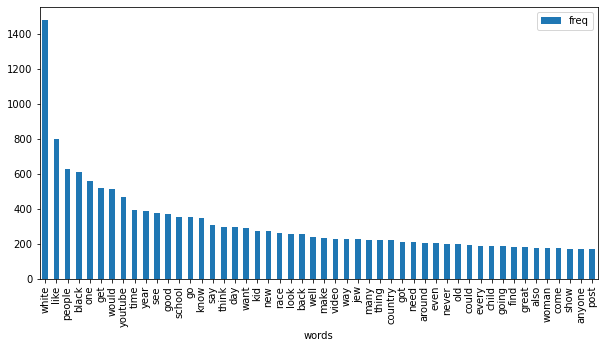

In [36]:
mcw.plot(x="words", y="freq", kind="bar", figsize=(10,5))
plt.show()

#### 3.1 Part of speech (POS)

In [37]:
from textblob import TextBlob
def pos_tag(text):
    try:
        return TextBlob(text).tags
    except:
        return None

In [38]:
print(TextBlob(data.iloc[4]["text_clean"]).tags)
print(TextBlob(data.iloc[4]["stemmed"]).tags)

[('click', 'NN'), ('download', 'NN'), ('megabytes', 'VBZ'), ('green', 'JJ'), ('banner', 'NN'), ('link', 'NN')]
[('click', 'NN'), ('download', 'NN'), ('megabyt', 'NN'), ('green', 'JJ'), ('banner', 'NN'), ('link', 'NN')]


In [39]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [40]:
data['POS_spacy'] = data['lemmatized'].progress_apply(lambda x: [(token.text, token.pos_) for token in nlp(x)])

100%|██████████| 10926/10926 [01:35<00:00, 113.95it/s]


In [41]:
all_pos = data['POS_spacy'].sum()

In [42]:
all_adjs = [x[0] for x in all_pos if x[1] == "ADJ"]
all_nouns = [x[0] for x in all_pos if x[1] == "NOUN"]

In [43]:
hate = data.loc[data["label"] == 1]

In [44]:
hate.shape[0], data.shape[0] # 1428 over 10926 rows

(1428, 10926)

In [45]:
data.label.value_counts()

0    9498
1    1428
Name: label, dtype: int64

In [46]:
all_pos_hate = hate['POS_spacy'].sum()

In [47]:
all_adjs_hate = [x[0] for x in all_pos_hate if x[1] == "ADJ"]
all_nouns_hate = [x[0] for x in all_pos_hate if x[1] == "NOUN"]

In [48]:
adj_counter = {}
for word in all_adjs:
    if word in adj_counter:
        adj_counter[word] += 1
    else:
        adj_counter[word] = 1

top_20_adj = {k: v for k, v in sorted(adj_counter.items(), key=lambda item: item[1], reverse=True)[:20]}
#pd.DataFrame.from_dict(top_20_adj, orient="index", columns=["Freq"]).reset_index()

In [49]:
noun_counter = {}
for word in all_nouns:
    if word in noun_counter:
        noun_counter[word] += 1
    else:
        noun_counter[word] = 1
            
top_20_noun = {k: v for k, v in sorted(noun_counter.items(), key=lambda item: item[1], reverse=True)[:20]}
#pd.DataFrame.from_dict(top_20_noun, orient="index", columns=["Freq"]).reset_index()

In [50]:
adj_counter1 = {}
for word in all_adjs_hate:
    if word in adj_counter1:
        adj_counter1[word] += 1
    else:
        adj_counter1[word] = 1
            
top_20_adj1 = {k: v for k, v in sorted(adj_counter1.items(), key=lambda item: item[1], reverse=True)[:20]}
#pd.DataFrame.from_dict(top_20_adj1, orient="index", columns=["Freq"]).reset_index()

In [51]:
noun_counter1 = {}
for word in all_nouns_hate:
    if word in noun_counter1:
        noun_counter1[word] += 1
    else:
        noun_counter1[word] = 1
            
top_20_noun1 = {k: v for k, v in sorted(noun_counter1.items(), key=lambda item: item[1], reverse=True)[:20]}
#pd.DataFrame.from_dict(top_20_noun1, orient="index", columns=["Freq"]).reset_index()

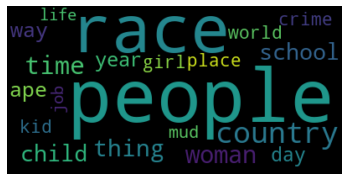

In [52]:
from wordcloud import WordCloud
wc = WordCloud().generate_from_frequencies(top_20_noun1)
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

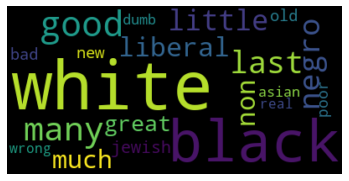

In [53]:
wc = WordCloud().generate_from_frequencies(top_20_adj1)
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [54]:
top_noun = {"Total": top_20_noun.keys(), "Freq_Total": top_20_noun.values(), "Hate_Speech": top_20_noun1.keys(), "Freq_Hate": top_20_noun1.values()}
top_noun = pd.DataFrame(top_noun)
top_noun["R_Freq_Total"] = top_noun.apply(lambda x: np.round(x.Freq_Total / top_noun.Freq_Total.sum(), 3), axis=1)
top_noun["R_Freq_Hate"] = top_noun.apply(lambda x: np.round(x.Freq_Hate / top_noun.Freq_Hate.sum(), 3), axis=1)
top_noun = top_noun.reindex(columns=['Total', 'R_Freq_Total', 'Hate_Speech', 'R_Freq_Hate'])
top_noun

,Total,R_Freq_Total,Hate_Speech,R_Freq_Hate
0,people,0.146,people,0.138
1,time,0.086,race,0.111
2,year,0.085,country,0.087
3,school,0.064,time,0.063
4,race,0.059,woman,0.058
5,day,0.054,thing,0.054
6,thing,0.049,child,0.051
7,country,0.048,school,0.051
8,video,0.044,way,0.043
9,child,0.044,ape,0.043


In [55]:
common_nouns = list(set(top_noun["Hate_Speech"].values).union(set(top_noun["Total"].values)))

In [56]:
freq_common_tot = [noun_counter[x] for x in common_nouns]
freq_common_hate = [noun_counter1[x] for x in common_nouns]

In [57]:
common_noun_df = pd.DataFrame({"Nouns" : common_nouns, "Freq_tot": freq_common_tot, "Freq_Hate_Speech": freq_common_hate })

In [58]:
common_noun_df.sort_values(by=["Freq_Hate_Speech"], ascending= False, inplace=True)

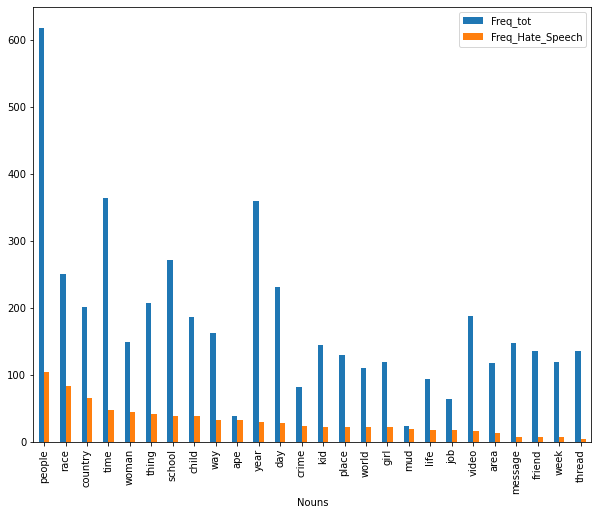

In [59]:
common_noun_df.plot('Nouns', y=['Freq_tot', 'Freq_Hate_Speech'], kind='bar', figsize=(10,8))
plt.show()

In [60]:
top_adj = {"Total": top_20_adj.keys(), "Freq_Total": top_20_adj.values(), "Hate_Speech": top_20_adj1.keys(), "Freq_Hate": top_20_adj1.values()}
top_adj = pd.DataFrame(top_adj)
top_adj["R_Freq_Total"] = top_adj.apply(lambda x: np.round(x.Freq_Total / top_adj.Freq_Total.sum(), 3), axis=1)
top_adj["R_Freq_Hate"] = top_adj.apply(lambda x: np.round(x.Freq_Hate / top_adj.Freq_Hate.sum(), 3), axis=1)
top_adj = top_adj.reindex(columns=['Total', 'R_Freq_Total', 'Hate_Speech', 'R_Freq_Hate'])
top_adj

,Total,R_Freq_Total,Hate_Speech,R_Freq_Hate
0,white,0.244,white,0.290
1,black,0.128,black,0.211
2,good,0.096,good,0.051
3,many,0.064,many,0.046
4,new,0.052,last,0.040
5,old,0.051,negro,0.038
6,last,0.045,little,0.033
7,great,0.042,liberal,0.029
8,little,0.033,non,0.028
9,much,0.032,much,0.027


In [61]:
common_adj = list(set(top_adj["Hate_Speech"].values).union(set(top_adj["Total"].values)))

In [62]:
freq_common_tot_adj = [adj_counter[x] for x in common_adj]
freq_common_hate_adj = [adj_counter1[x] for x in common_adj]

In [63]:
common_adj_df = pd.DataFrame({"Adj" : common_adj, "Freq_tot": freq_common_tot_adj, "Freq_Hate_Speech": freq_common_hate_adj })

In [64]:
common_adj_df.sort_values(by=["Freq_Hate_Speech"], ascending= False, inplace=True)

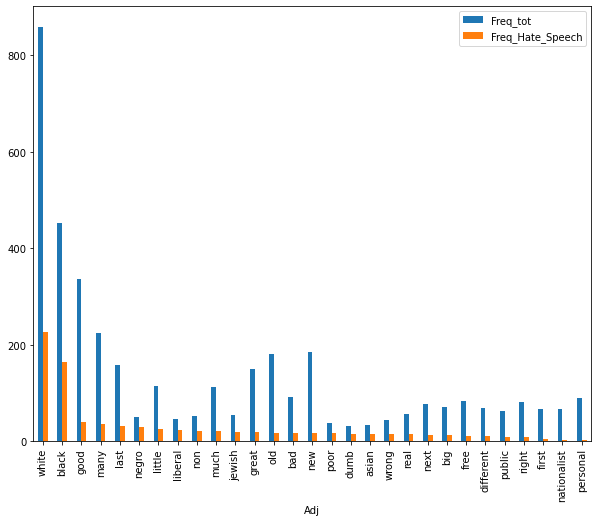

In [65]:
common_adj_df.plot(x='Adj', y=['Freq_tot', 'Freq_Hate_Speech'], kind='bar', figsize=(10,8))
plt.show()

In [67]:
pos_counter = {}
for x in all_pos:
    if x[1] in pos_counter:
        pos_counter[x[1]] += 1
    else:
        pos_counter[x[1]] = 1
        
top_pos = {k: v for k, v in sorted(pos_counter.items(), key=lambda item: item[1], reverse=True)}

In [68]:
freq_pos = pd.DataFrame.from_dict(top_pos, orient="index", columns=["Freq"]).reset_index()
freq_pos["R_Freq"] = freq_pos.apply(lambda x: np.round(x.Freq / freq_pos.Freq.sum(), 2), axis=1)

In [69]:
pos_counter_hate = {}
for x in all_pos_hate:
    if x[1] in pos_counter_hate:
        pos_counter_hate[x[1]] += 1
    else:
        pos_counter_hate[x[1]] = 1
        
top_pos_hate = {k: v for k, v in sorted(pos_counter_hate.items(), key=lambda item: item[1], reverse=True)}

In [70]:
freq_pos_hate = pd.DataFrame.from_dict(top_pos_hate, orient="index", columns=["Freq"]).reset_index()
freq_pos_hate["R_Freq"] = freq_pos_hate.apply(lambda x: np.round(x.Freq / freq_pos_hate.Freq.sum(), 2), axis=1)

In [71]:
compared_pos = {"Total": top_pos.keys(), "Freq_Total": top_pos.values(), "Hate_Speech": top_pos_hate.keys(), "Freq_Hate": top_pos_hate.values()}
compared_pos = pd.DataFrame(compared_pos)
compared_pos["R_Freq_Total"] = compared_pos.apply(lambda x: np.round(x.Freq_Total / compared_pos.Freq_Total.sum(), 3), axis=1)
compared_pos["R_Freq_Hate"] = compared_pos.apply(lambda x: np.round(x.Freq_Hate / compared_pos.Freq_Hate.sum(), 3), axis=1)
compared_pos = compared_pos.reindex(columns=['Total', 'R_Freq_Total', 'Hate_Speech', 'R_Freq_Hate'])
compared_pos[:7]

,Total,R_Freq_Total,Hate_Speech,R_Freq_Hate
0,NOUN,0.291,NOUN,0.284
1,PROPN,0.236,PROPN,0.228
2,VERB,0.205,VERB,0.211
3,ADJ,0.133,ADJ,0.149
4,ADV,0.059,ADV,0.060
5,PRON,0.013,SCONJ,0.012
6,INTJ,0.012,PRON,0.011


# SPELLING

In [72]:
import nltk
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [73]:
def unusual_words(text):
    text_vocab = set(w.lower() for w in text if w.isalpha())
    english_vocab = set(w.lower() for w in nltk.corpus.words.words())
    unusual = text_vocab.difference(english_vocab)
    return sorted(unusual)

In [74]:
crt = unusual_words(data['lemmatized'])
print(crt)

['africa', 'aragorn', 'asked', 'asking', 'asmodean', 'bb', 'braun', 'btl', 'calman', 'camie', 'cf', 'cheaper', 'congrats', 'contradicting', 'cripppinnn', 'czynski', 'dallas', 'dc', 'downloads', 'dr', 'dublin', 'ebonics', 'edmonton', 'elmira', 'embarassing', 'fbi', 'gille', 'groupid', 'gyspsies', 'haha', 'hahahahahaha', 'heil', 'hups', 'hz', 'ii', 'iii', 'im', 'internet', 'iv', 'jpg', 'kaboom', 'kid', 'kidding', 'kr', 'lk', 'located', 'lol', 'meh', 'minnesota', 'mmm', 'motivated', 'mrbadgersir', 'msciwoj', 'muahaha', 'needed', 'neofolk', 'nigga', 'okay', 'opendocument', 'opps', 'patrioticmama', 'pawel', 'pffffft', 'politifuldm', 'reproducing', 'rumour', 'stormfront', 'studying', 'sveiks', 'swva', 'tereasa', 'tf', 'threadid', 'tnb', 'topix', 'tv', 'twp', 'ty', 'usa', 'vancouver', 'weku', 'wellsburg', 'whiteutopian', 'wierd', 'wiki', 'wntube', 'wp', 'wpww', 'wrs', 'wulfi', 'wv', 'youtube', 'yuenglings', 'yup', 'zdrowie']


In [75]:
corrected_w =[TextBlob(word).correct().words[0] for word in crt]
corrected_w

['africa',
 'dragoon',
 'asked',
 'asking',
 'asmodean',
 'by',
 'brain',
 'bal',
 'cabman',
 'came',
 'cf',
 'cheaper',
 'congress',
 'contradicting',
 'cripppinnn',
 'czynski',
 'dallas',
 'do',
 'download',
 'dr',
 'dublin',
 'tonics',
 'edmonton',
 'eliza',
 'embarrassing',
 'foi',
 'ville',
 'grouped',
 'gypsies',
 'hata',
 'hahahahahaha',
 'heal',
 'huts',
 'he',
 'ii',
 'iii',
 'in',
 'internet',
 'iv',
 'pg',
 'boom',
 'kid',
 'bidding',
 'or',
 'll',
 'located',
 'll',
 'me',
 'minnesota',
 'mmm',
 'motivate',
 'mrbadgersir',
 'msciwoj',
 'muahaha',
 'needed',
 'norfolk',
 'night',
 'okay',
 'opendocument',
 'open',
 'patrioticmama',
 'panel',
 'pffffft',
 'politifuldm',
 'reproducing',
 'rumour',
 'stormfront',
 'studying',
 'veins',
 'saw',
 'theresa',
 'of',
 'thread',
 'tub',
 'topic',
 'to',
 'two',
 'ty',
 'us',
 'vancouver',
 'wetu',
 'wellsburg',
 'whiteutopian',
 'wired',
 'wiki',
 'tube',
 'up',
 'www',
 'was',
 'wolf',
 'we',
 'couture',
 'yuenglings',
 'up',
 'zdro

In [76]:
from autocorrect import Speller
def autocorr(text):
    crt = unusual_words(text)
    for t in crt:
        auto = Speller(lang='en')
        corr = auto(t)
        if t != corr:
            print(t, corr)

In [77]:
autocorr(data['lemmatized']) ##

aragorn dragon
btl bl
calman salman
camie came
congrats contrast
elmira lira
embarassing embarrassing
gille ville
groupid grouped
heil heir
hups ups
kaboom boom
neofolk norfolk
nigga nigra
opps apps
pawel panel
pffffft ffffff
stormfront storefront
sveiks speaks
swva swa
tereasa teresa
threadid threaded
tnb nb
topix topic
weku wek
wierd weird
wntube tube
wpww www
wulfi multi


In [78]:
# sentiment polarity TEXTBLOB https://textblob.readthedocs.io/en/dev/quickstart.html

# 4. MODELS

In [79]:
tfidf_vectorizer = TfidfVectorizer()
X_class = tfidf_vectorizer.fit_transform(data['lemmatized'])
y_class = data["label"]
X_class.shape

(10926, 12731)

In [80]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.3, random_state=42, stratify=y_class)

In [81]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import sklearn as sk
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
random_state = np.random.RandomState(0)

In [82]:
# Multinomial Naive Bayes
mnb = MultinomialNB(alpha=0.01)
mnb.fit(X_train, y_train)
y_mnb = mnb.predict(X_test)
as_mnb = accuracy_score(y_test, y_mnb)
f1s_mnb = f1_score(y_test, y_mnb, average= "macro")
prec_mnb = precision_score(y_test, y_mnb)
rec_mnb = recall_score(y_test, y_mnb, average='macro')
print(confusion_matrix(y_test,y_mnb))
print(classification_report(y_test,y_mnb))
print(accuracy_score(y_test, y_mnb))

[[2696  154]
 [ 323  105]]
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      2850
           1       0.41      0.25      0.31       428

    accuracy                           0.85      3278
   macro avg       0.65      0.60      0.61      3278
weighted avg       0.83      0.85      0.84      3278

0.8544844417327638


In [83]:
# Support Vector Machine
svc = SVC(verbose=10)
svc.fit(X_train, y_train)
y_svc = svc.predict(X_test)
as_svc = accuracy_score(y_test, y_svc)
f1s_svc = f1_score(y_test, y_svc, average="macro")
prec_svc = precision_score(y_test, y_svc)
rec_svc = recall_score(y_test, y_svc, average='macro')
print(confusion_matrix(y_test,y_svc))
print(classification_report(y_test,y_svc))
print(accuracy_score(y_test, y_svc))

[LibSVM][[2847    3]
 [ 407   21]]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      2850
           1       0.88      0.05      0.09       428

    accuracy                           0.87      3278
   macro avg       0.87      0.52      0.51      3278
weighted avg       0.87      0.87      0.82      3278

0.8749237339841367


In [84]:
# Logistic
log_fit = LogisticRegression(random_state=42).fit(X_train, y_train)
y_log = log_fit.predict(X_test)
as_log = accuracy_score(y_test, y_log)
f1s_log = f1_score(y_test, y_log, average= "macro")
prec_log = precision_score(y_test, y_log)
rec_log = recall_score(y_test, y_log, average='macro')
print(confusion_matrix(y_test,y_log))
print(classification_report(y_test,y_log))
print(accuracy_score(y_test, y_log))

[[2839   11]
 [ 400   28]]
              precision    recall  f1-score   support

           0       0.88      1.00      0.93      2850
           1       0.72      0.07      0.12       428

    accuracy                           0.87      3278
   macro avg       0.80      0.53      0.53      3278
weighted avg       0.86      0.87      0.83      3278

0.8746186699206834


In [85]:
# Random Forest
rf = RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(X_train, y_train) 
y_rf = rf.predict(X_test)
as_rf = accuracy_score(y_test, y_rf)
f1s_rf = f1_score(y_test, y_rf, average= "macro")
prec_rf = precision_score(y_test, y_rf)
rec_rf = recall_score(y_test, y_rf, average='macro')
print(confusion_matrix(y_test,y_rf))
print(classification_report(y_test,y_rf))
print(accuracy_score(y_test, y_rf))

[[2822   28]
 [ 379   49]]
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      2850
           1       0.64      0.11      0.19       428

    accuracy                           0.88      3278
   macro avg       0.76      0.55      0.56      3278
weighted avg       0.85      0.88      0.84      3278

0.8758389261744967


In [86]:
# Neural Networks
NN = MLPClassifier(random_state=42, max_iter=50)
NN.fit(X_train, y_train)
y_NN = NN.predict(X_test)
as_NN = accuracy_score(y_test, y_NN)
f1s_NN = f1_score(y_test, y_NN, average= "macro")
prec_NN = precision_score(y_test, y_NN)
rec_NN = recall_score(y_test, y_NN, average='macro')
print(confusion_matrix(y_test,y_NN))
print(classification_report(y_test,y_NN))
print(accuracy_score(y_test, y_NN))

[[2673  177]
 [ 297  131]]
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      2850
           1       0.43      0.31      0.36       428

    accuracy                           0.86      3278
   macro avg       0.66      0.62      0.64      3278
weighted avg       0.84      0.86      0.85      3278

0.8553996339231239


C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [87]:
# Decision Tree
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_tree = tree.predict(X_test)
as_tree = accuracy_score(y_test, y_tree)
f1s_tree = f1_score(y_test, y_tree, average= "macro")
prec_tree = precision_score(y_test, y_tree)
rec_tree = recall_score(y_test, y_tree, average='macro')
print(confusion_matrix(y_test,y_tree))
print(classification_report(y_test,y_tree))
print(accuracy_score(y_test, y_tree))

[[2628  222]
 [ 271  157]]
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      2850
           1       0.41      0.37      0.39       428

    accuracy                           0.85      3278
   macro avg       0.66      0.64      0.65      3278
weighted avg       0.84      0.85      0.85      3278

0.8496034167175107


In [88]:
# K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_knn = knn.predict(X_test)
as_knn = accuracy_score(y_test, y_knn)
f1s_knn = f1_score(y_test, y_knn, average= "macro")
prec_knn = precision_score(y_test, y_knn)
rec_knn = recall_score(y_test, y_knn, average='macro')
print(confusion_matrix(y_test,y_knn))
print(classification_report(y_test,y_knn))
print(accuracy_score(y_test, y_knn))

[[2850    0]
 [ 419    9]]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      2850
           1       1.00      0.02      0.04       428

    accuracy                           0.87      3278
   macro avg       0.94      0.51      0.49      3278
weighted avg       0.89      0.87      0.82      3278

0.8721781574130567


In [89]:
s1 = pd.Series([as_mnb, as_svc, as_log, as_rf, as_NN, as_tree, as_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s2 = pd.Series([f1s_mnb, f1s_svc, f1s_log, f1s_rf, f1s_NN, f1s_tree, f1s_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression','Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s3 = pd.Series([prec_mnb, prec_svc, prec_log, prec_rf, prec_NN, prec_tree, prec_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s4 = pd.Series([rec_mnb, rec_svc, rec_log, rec_rf, rec_NN, rec_tree, rec_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
d = {'Accuracy Score' : s1, 'Precision Score': s3, 'Recall Score' : s4, 'F1 Score' : s2 }
dfm = pd.DataFrame(d)
dfm.style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'tomato', axis = 0)

,Accuracy Score,Precision Score,Recall Score,F1 Score
Multinomial Naive Bayes,0.854484,0.405405,0.595646,0.612201
Support Vector Machine,0.874924,0.875000,0.524006,0.512876
Logistic Regression,0.874619,0.717949,0.530780,0.526208
Random Forest,0.875839,0.636364,0.552331,0.563399
Neural Networks,0.855400,0.425325,0.621985,0.637267
Decision Tree,0.849603,0.414248,0.644464,0.651671
K-Nearest Neighbors,0.872178,1.000000,0.510514,0.486357


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.88')

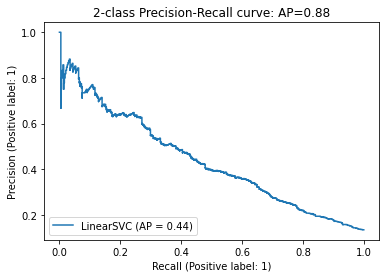

In [90]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

classifier = svm.LinearSVC(random_state=random_state)
classifier.fit(X_train, y_train)

disp = plot_precision_recall_curve(classifier, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(prec_svc))

# 4.1 Imbalanced

In [91]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler 
undersample = RandomUnderSampler(sampling_strategy='majority')

In [92]:
X_over, y_over = undersample.fit_resample(X_class, y_class)

In [93]:
from collections import Counter
print(Counter(y_over))

Counter({0: 1428, 1: 1428})


In [94]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.3, random_state=42, stratify=y_over)

In [95]:
# Multinomial Naive Bayes
mnb_i = MultinomialNB(alpha=0.01)
mnb_i.fit(X_train, y_train)
y_mnb_i = mnb_i.predict(X_test)
as_mnb_i = accuracy_score(y_test, y_mnb_i)
f1s_mnb_i = f1_score(y_test, y_mnb_i, average= "macro")
prec_mnb_i = precision_score(y_test, y_mnb_i)
rec_mnb_i = recall_score(y_test, y_mnb_i, average='macro')
print(confusion_matrix(y_test,y_mnb_i))
print(classification_report(y_test,y_mnb_i))
print(accuracy_score(y_test, y_mnb_i))

[[263 166]
 [131 297]]
              precision    recall  f1-score   support

           0       0.67      0.61      0.64       429
           1       0.64      0.69      0.67       428

    accuracy                           0.65       857
   macro avg       0.65      0.65      0.65       857
weighted avg       0.65      0.65      0.65       857

0.6534422403733956


In [96]:
# Support Vector Machine
svc_i = SVC(verbose=10)
svc_i.fit(X_train, y_train)
y_svc_i = svc_i.predict(X_test)
as_svc_i = accuracy_score(y_test, y_svc_i)
f1s_svc_i = f1_score(y_test, y_svc_i, average="macro")
prec_svc_i = precision_score(y_test, y_svc_i)
rec_svc_i = recall_score(y_test, y_svc_i, average='macro')
print(confusion_matrix(y_test,y_svc_i))
print(classification_report(y_test,y_svc_i))
print(accuracy_score(y_test, y_svc_i))

[LibSVM][[334  95]
 [145 283]]
              precision    recall  f1-score   support

           0       0.70      0.78      0.74       429
           1       0.75      0.66      0.70       428

    accuracy                           0.72       857
   macro avg       0.72      0.72      0.72       857
weighted avg       0.72      0.72      0.72       857

0.7199533255542591


In [97]:
# Logistic
log_fit_i = LogisticRegression(random_state=42).fit(X_train, y_train)
y_log_i = log_fit_i.predict(X_test)
as_log_i = accuracy_score(y_test, y_log_i)
f1s_log_i = f1_score(y_test, y_log_i, average= "macro")
prec_log_i = precision_score(y_test, y_log_i)
rec_log_i = recall_score(y_test, y_log_i, average='macro')
print(confusion_matrix(y_test,y_log_i))
print(classification_report(y_test,y_log_i))
print(accuracy_score(y_test, y_log_i))

[[337  92]
 [141 287]]
              precision    recall  f1-score   support

           0       0.71      0.79      0.74       429
           1       0.76      0.67      0.71       428

    accuracy                           0.73       857
   macro avg       0.73      0.73      0.73       857
weighted avg       0.73      0.73      0.73       857

0.7281213535589265


In [98]:
# Random Forest
rf_i = RandomForestClassifier(n_estimators=10, random_state=42)
rf_i.fit(X_train, y_train) 
y_rf_i = rf_i.predict(X_test)
as_rf_i = accuracy_score(y_test, y_rf_i)
f1s_rf_i = f1_score(y_test, y_rf_i, average= "macro")
prec_rf_i = precision_score(y_test, y_rf_i)
rec_rf_i = recall_score(y_test, y_rf_i, average='macro')
print(confusion_matrix(y_test,y_rf_i))
print(classification_report(y_test,y_rf_i))
print(accuracy_score(y_test, y_rf_i))

[[345  84]
 [209 219]]
              precision    recall  f1-score   support

           0       0.62      0.80      0.70       429
           1       0.72      0.51      0.60       428

    accuracy                           0.66       857
   macro avg       0.67      0.66      0.65       857
weighted avg       0.67      0.66      0.65       857

0.6581096849474912


In [99]:
# Neural Networks
NN_i = MLPClassifier(random_state=42, max_iter=10)
NN_i.fit(X_train, y_train)
#NN.score(X_test, y_test)
y_NN_i = NN_i.predict(X_test)
as_NN_i = accuracy_score(y_test, y_NN_i)
f1s_NN_i = f1_score(y_test, y_NN_i, average= "macro")
prec_NN_i = precision_score(y_test, y_NN_i)
rec_NN_i = recall_score(y_test, y_NN_i, average='macro')
print(confusion_matrix(y_test,y_NN_i))
print(classification_report(y_test,y_NN_i))
print(accuracy_score(y_test, y_NN_i))

[[310 119]
 [144 284]]
              precision    recall  f1-score   support

           0       0.68      0.72      0.70       429
           1       0.70      0.66      0.68       428

    accuracy                           0.69       857
   macro avg       0.69      0.69      0.69       857
weighted avg       0.69      0.69      0.69       857

0.6931155192532089


C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


In [100]:
# Decision Tree
tree_i = DecisionTreeClassifier()
tree_i.fit(X_train, y_train)
y_tree_i = tree_i.predict(X_test)
as_tree_i = accuracy_score(y_test, y_tree_i)
f1s_tree_i = f1_score(y_test, y_tree_i, average= "macro")
prec_tree_i = precision_score(y_test, y_tree_i)
rec_tree_i = recall_score(y_test, y_tree_i, average='macro')
print(confusion_matrix(y_test,y_tree_i))
print(classification_report(y_test,y_tree_i))
print(accuracy_score(y_test, y_tree_i))

[[304 125]
 [169 259]]
              precision    recall  f1-score   support

           0       0.64      0.71      0.67       429
           1       0.67      0.61      0.64       428

    accuracy                           0.66       857
   macro avg       0.66      0.66      0.66       857
weighted avg       0.66      0.66      0.66       857

0.6569428238039673


In [101]:
# K-Nearest Neighbors
knn_i = KNeighborsClassifier()
knn_i.fit(X_train, y_train)
y_knn_i = knn_i.predict(X_test)
as_knn_i = accuracy_score(y_test, y_knn_i)
f1s_knn_i = f1_score(y_test, y_knn_i, average= "macro")
prec_knn_i = precision_score(y_test, y_knn_i)
rec_knn_i = recall_score(y_test, y_knn_i, average='macro')
print(confusion_matrix(y_test,y_knn_i))
print(classification_report(y_test,y_knn_i))
print(accuracy_score(y_test, y_knn_i))

[[428   1]
 [413  15]]
              precision    recall  f1-score   support

           0       0.51      1.00      0.67       429
           1       0.94      0.04      0.07       428

    accuracy                           0.52       857
   macro avg       0.72      0.52      0.37       857
weighted avg       0.72      0.52      0.37       857

0.5169194865810969


In [102]:
s1_i = pd.Series([as_mnb_i, as_svc_i, as_log_i, as_rf_i, as_NN_i, as_tree_i, as_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s2_i = pd.Series([f1s_mnb_i, f1s_svc_i, f1s_log_i, f1s_rf_i, f1s_NN_i, f1s_tree_i, f1s_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression','Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s3_i = pd.Series([prec_mnb_i, prec_svc_i, prec_log_i, prec_rf_i, prec_NN_i, prec_tree_i, prec_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s4_i = pd.Series([rec_mnb, rec_svc, rec_log, rec_rf, rec_NN, rec_tree, rec_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
d_i = {'Accuracy Score' : s1_i, 'Precision Score': s3_i, 'Recall Score' : s4_i, 'F1 Score' : s2_i}
dfm_i = pd.DataFrame(d_i)
dfm_i.style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'tomato', axis = 0)

,Accuracy Score,Precision Score,Recall Score,F1 Score
Multinomial Naive Bayes,0.653442,0.641469,0.595646,0.652896
Support Vector Machine,0.719953,0.748677,0.524006,0.718958
Logistic Regression,0.728121,0.757256,0.530780,0.727193
Random Forest,0.658110,0.722772,0.552331,0.650556
Neural Networks,0.693116,0.704715,0.621985,0.692833
Decision Tree,0.656943,0.674479,0.644464,0.655994
K-Nearest Neighbors,0.516919,0.937500,0.510514,0.370792


## 4.2 Models on POS

In [103]:
def filter_text_pos(x):
    final_pos_text = []
    for elem in x:
        for pos in pos_list:
            if elem[1] == pos:
                final_pos_text.append(elem[0])
    
    return " ".join(final_pos_text)

### 4.2.1 Proper Nouns

In [104]:
pos_list = ["PROPN"]

In [105]:
data["PROPN"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)

In [106]:
tfidf_vectorizer = TfidfVectorizer()
X_Propn = tfidf_vectorizer.fit_transform(data["PROPN"])
y_Propn = data["label"]
X_Propn.shape

(10926, 6632)

In [107]:
X_over, y_over = undersample.fit_resample(X_Propn, y_Propn)

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.3, random_state=42, stratify=y_over)

In [109]:
# Multinomial Naive Bayes
mnb_i = MultinomialNB(alpha=0.01)
mnb_i.fit(X_train, y_train)
y_mnb_i = mnb_i.predict(X_test)
as_mnb_i = accuracy_score(y_test, y_mnb_i)
f1s_mnb_i = f1_score(y_test, y_mnb_i, average= "macro")
prec_mnb_i = precision_score(y_test, y_mnb_i)
rec_mnb_i = recall_score(y_test, y_mnb_i, average='macro')
print(confusion_matrix(y_test,y_mnb_i))
print(classification_report(y_test,y_mnb_i))
print(accuracy_score(y_test, y_mnb_i))

[[159 270]
 [117 311]]
              precision    recall  f1-score   support

           0       0.58      0.37      0.45       429
           1       0.54      0.73      0.62       428

    accuracy                           0.55       857
   macro avg       0.56      0.55      0.53       857
weighted avg       0.56      0.55      0.53       857

0.5484247374562428


In [110]:
# Support Vector Machine
svc_i = SVC(verbose=10)
svc_i.fit(X_train, y_train)
y_svc_i = svc_i.predict(X_test)
as_svc_i = accuracy_score(y_test, y_svc_i)
f1s_svc_i = f1_score(y_test, y_svc_i, average="macro")
prec_svc_i = precision_score(y_test, y_svc_i)
rec_svc_i = recall_score(y_test, y_svc_i, average='macro')
print(confusion_matrix(y_test,y_svc_i))
print(classification_report(y_test,y_svc_i))
print(accuracy_score(y_test, y_svc_i))

[LibSVM][[280 149]
 [184 244]]
              precision    recall  f1-score   support

           0       0.60      0.65      0.63       429
           1       0.62      0.57      0.59       428

    accuracy                           0.61       857
   macro avg       0.61      0.61      0.61       857
weighted avg       0.61      0.61      0.61       857

0.6114352392065344


In [111]:
# Logistic
log_fit_i = LogisticRegression(random_state=42).fit(X_train, y_train)
y_log_i = log_fit_i.predict(X_test)
as_log_i = accuracy_score(y_test, y_log_i)
f1s_log_i = f1_score(y_test, y_log_i, average= "macro")
prec_log_i = precision_score(y_test, y_log_i)
rec_log_i = recall_score(y_test, y_log_i, average='macro')
print(confusion_matrix(y_test,y_log_i))
print(classification_report(y_test,y_log_i))
print(accuracy_score(y_test, y_log_i))

[[361  68]
 [244 184]]
              precision    recall  f1-score   support

           0       0.60      0.84      0.70       429
           1       0.73      0.43      0.54       428

    accuracy                           0.64       857
   macro avg       0.66      0.64      0.62       857
weighted avg       0.66      0.64      0.62       857

0.6359393232205367


In [112]:
# Random Forest
rf_i = RandomForestClassifier(n_estimators=10, random_state=42)
rf_i.fit(X_train, y_train) 
y_rf_i = rf_i.predict(X_test)
as_rf_i = accuracy_score(y_test, y_rf_i)
f1s_rf_i = f1_score(y_test, y_rf_i, average= "macro")
prec_rf_i = precision_score(y_test, y_rf_i)
rec_rf_i = recall_score(y_test, y_rf_i, average='macro')
print(confusion_matrix(y_test,y_rf_i))
print(classification_report(y_test,y_rf_i))
print(accuracy_score(y_test, y_rf_i))

[[362  67]
 [259 169]]
              precision    recall  f1-score   support

           0       0.58      0.84      0.69       429
           1       0.72      0.39      0.51       428

    accuracy                           0.62       857
   macro avg       0.65      0.62      0.60       857
weighted avg       0.65      0.62      0.60       857

0.6196032672112018


In [113]:
# Neural Networks
NN_i = MLPClassifier(random_state=42, max_iter=50)
NN_i.fit(X_train, y_train)
#NN.score(X_test, y_test)
y_NN_i = NN_i.predict(X_test)
as_NN_i = accuracy_score(y_test, y_NN_i)
f1s_NN_i = f1_score(y_test, y_NN_i, average= "macro")
prec_NN_i = precision_score(y_test, y_NN_i)
rec_NN_i = recall_score(y_test, y_NN_i, average='macro')
print(confusion_matrix(y_test,y_NN_i))
print(classification_report(y_test,y_NN_i))
print(accuracy_score(y_test, y_NN_i))

[[341  88]
 [241 187]]
              precision    recall  f1-score   support

           0       0.59      0.79      0.67       429
           1       0.68      0.44      0.53       428

    accuracy                           0.62       857
   macro avg       0.63      0.62      0.60       857
weighted avg       0.63      0.62      0.60       857

0.6161026837806302


C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [114]:
# Decision Tree
tree_i = DecisionTreeClassifier()
tree_i.fit(X_train, y_train)
y_tree_i = tree_i.predict(X_test)
as_tree_i = accuracy_score(y_test, y_tree_i)
f1s_tree_i = f1_score(y_test, y_tree_i, average= "macro")
prec_tree_i = precision_score(y_test, y_tree_i)
rec_tree_i = recall_score(y_test, y_tree_i, average='macro')
print(confusion_matrix(y_test,y_tree_i))
print(classification_report(y_test,y_tree_i))
print(accuracy_score(y_test, y_tree_i))

[[369  60]
 [265 163]]
              precision    recall  f1-score   support

           0       0.58      0.86      0.69       429
           1       0.73      0.38      0.50       428

    accuracy                           0.62       857
   macro avg       0.66      0.62      0.60       857
weighted avg       0.66      0.62      0.60       857

0.6207701283547258


In [115]:
# K-Nearest Neighbors
knn_i = KNeighborsClassifier()
knn_i.fit(X_train, y_train)
y_knn_i = knn_i.predict(X_test)
as_knn_i = accuracy_score(y_test, y_knn_i)
f1s_knn_i = f1_score(y_test, y_knn_i, average= "macro")
prec_knn_i = precision_score(y_test, y_knn_i)
rec_knn_i = recall_score(y_test, y_knn_i, average='macro')
print(confusion_matrix(y_test,y_knn_i))
print(classification_report(y_test,y_knn_i))
print(accuracy_score(y_test, y_knn_i))

[[414  15]
 [356  72]]
              precision    recall  f1-score   support

           0       0.54      0.97      0.69       429
           1       0.83      0.17      0.28       428

    accuracy                           0.57       857
   macro avg       0.68      0.57      0.49       857
weighted avg       0.68      0.57      0.49       857

0.5670945157526255


In [116]:
s1_i = pd.Series([as_mnb_i, as_svc_i, as_log_i, as_rf_i, as_NN_i, as_tree_i, as_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s2_i = pd.Series([f1s_mnb_i, f1s_svc_i, f1s_log_i, f1s_rf_i, f1s_NN_i, f1s_tree_i, f1s_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression','Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s3_i = pd.Series([prec_mnb_i, prec_svc_i, prec_log_i, prec_rf_i, prec_NN_i, prec_tree_i, prec_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s4_i = pd.Series([rec_mnb, rec_svc, rec_log, rec_rf, rec_NN, rec_tree, rec_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
d_i = {'Accuracy Score' : s1_i, 'Precision Score': s3_i, 'Recall Score' : s4_i, 'F1 Score' : s2_i}
dfm_i = pd.DataFrame(d_i)
dfm_i.style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'tomato', axis = 0)

,Accuracy Score,Precision Score,Recall Score,F1 Score
Multinomial Naive Bayes,0.548425,0.535284,0.595646,0.533758
Support Vector Machine,0.611435,0.620865,0.524006,0.610748
Logistic Regression,0.635939,0.730159,0.530780,0.619718
Random Forest,0.619603,0.716102,0.552331,0.599280
Neural Networks,0.616103,0.680000,0.621985,0.603293
Decision Tree,0.620770,0.730942,0.644464,0.597515
K-Nearest Neighbors,0.567095,0.827586,0.510514,0.485094


In [117]:
# Considering only PROPN in tfidf and models, the results for "hate speech" (label = 1) have higher levels of precision, both wrt "no hate" (except Mnb) and also to other POS (ex: NOUN has Precision Score below 0.668).

### 4.2.2 Nouns + Proper Nouns + Verbs

In [118]:
pos_list = ["NOUN","PROPN", "VERB"]

In [119]:
data["NOUN_PROPN_VERB"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)

In [120]:
tfidf_vectorizer = TfidfVectorizer()
X_NounPropnVerb = tfidf_vectorizer.fit_transform(data["NOUN_PROPN_VERB"])
y_NounPropnVerb = data["label"]
X_NounPropnVerb.shape

(10926, 11066)

In [121]:
X_over, y_over = undersample.fit_resample(X_NounPropnVerb, y_NounPropnVerb)

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.3, random_state=42, stratify=y_over)

In [123]:
# Multinomial Naive Bayes
mnb_i = MultinomialNB(alpha=0.01)
mnb_i.fit(X_train, y_train)
y_mnb_i = mnb_i.predict(X_test)
as_mnb_i = accuracy_score(y_test, y_mnb_i)
f1s_mnb_i = f1_score(y_test, y_mnb_i, average= "macro")
prec_mnb_i = precision_score(y_test, y_mnb_i)
rec_mnb_i = recall_score(y_test, y_mnb_i, average='macro')
print(confusion_matrix(y_test,y_mnb_i))
print(classification_report(y_test,y_mnb_i))
print(accuracy_score(y_test, y_mnb_i))

[[254 175]
 [122 306]]
              precision    recall  f1-score   support

           0       0.68      0.59      0.63       429
           1       0.64      0.71      0.67       428

    accuracy                           0.65       857
   macro avg       0.66      0.65      0.65       857
weighted avg       0.66      0.65      0.65       857

0.6534422403733956


In [124]:
# Support Vector Machine
svc_i = SVC(verbose=10)
svc_i.fit(X_train, y_train)
y_svc_i = svc_i.predict(X_test)
as_svc_i = accuracy_score(y_test, y_svc_i)
f1s_svc_i = f1_score(y_test, y_svc_i, average="macro")
prec_svc_i = precision_score(y_test, y_svc_i)
rec_svc_i = recall_score(y_test, y_svc_i, average='macro')
print(confusion_matrix(y_test,y_svc_i))
print(classification_report(y_test,y_svc_i))
print(accuracy_score(y_test, y_svc_i))

[LibSVM][[319 110]
 [146 282]]
              precision    recall  f1-score   support

           0       0.69      0.74      0.71       429
           1       0.72      0.66      0.69       428

    accuracy                           0.70       857
   macro avg       0.70      0.70      0.70       857
weighted avg       0.70      0.70      0.70       857

0.7012835472578763


In [125]:
# Logistic
log_fit_i = LogisticRegression(random_state=42).fit(X_train, y_train)
y_log_i = log_fit_i.predict(X_test)
as_log_i = accuracy_score(y_test, y_log_i)
f1s_log_i = f1_score(y_test, y_log_i, average= "macro")
prec_log_i = precision_score(y_test, y_log_i)
rec_log_i = recall_score(y_test, y_log_i, average='macro')
print(confusion_matrix(y_test,y_log_i))
print(classification_report(y_test,y_log_i))
print(accuracy_score(y_test, y_log_i))

[[329 100]
 [158 270]]
              precision    recall  f1-score   support

           0       0.68      0.77      0.72       429
           1       0.73      0.63      0.68       428

    accuracy                           0.70       857
   macro avg       0.70      0.70      0.70       857
weighted avg       0.70      0.70      0.70       857

0.6989498249708285


In [126]:
# Random Forest
rf_i = RandomForestClassifier(n_estimators=10, random_state=42)
rf_i.fit(X_train, y_train) 
y_rf_i = rf_i.predict(X_test)
as_rf_i = accuracy_score(y_test, y_rf_i)
f1s_rf_i = f1_score(y_test, y_rf_i, average= "macro")
prec_rf_i = precision_score(y_test, y_rf_i)
rec_rf_i = recall_score(y_test, y_rf_i, average='macro')
print(confusion_matrix(y_test,y_rf_i))
print(classification_report(y_test,y_rf_i))
print(accuracy_score(y_test, y_rf_i))

[[339  90]
 [200 228]]
              precision    recall  f1-score   support

           0       0.63      0.79      0.70       429
           1       0.72      0.53      0.61       428

    accuracy                           0.66       857
   macro avg       0.67      0.66      0.66       857
weighted avg       0.67      0.66      0.66       857

0.661610268378063


In [127]:
# Neural Networks
NN_i = MLPClassifier(random_state=42, max_iter=50)
NN_i.fit(X_train, y_train)
#NN.score(X_test, y_test)
y_NN_i = NN_i.predict(X_test)
as_NN_i = accuracy_score(y_test, y_NN_i)
f1s_NN_i = f1_score(y_test, y_NN_i, average= "macro")
prec_NN_i = precision_score(y_test, y_NN_i)
rec_NN_i = recall_score(y_test, y_NN_i, average='macro')
print(confusion_matrix(y_test,y_NN_i))
print(classification_report(y_test,y_NN_i))
print(accuracy_score(y_test, y_NN_i))

[[292 137]
 [149 279]]
              precision    recall  f1-score   support

           0       0.66      0.68      0.67       429
           1       0.67      0.65      0.66       428

    accuracy                           0.67       857
   macro avg       0.67      0.67      0.67       857
weighted avg       0.67      0.67      0.67       857

0.6662777129521587


C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [128]:
# Decision Tree
tree_i = DecisionTreeClassifier()
tree_i.fit(X_train, y_train)
y_tree_i = tree_i.predict(X_test)
as_tree_i = accuracy_score(y_test, y_tree_i)
f1s_tree_i = f1_score(y_test, y_tree_i, average= "macro")
prec_tree_i = precision_score(y_test, y_tree_i)
rec_tree_i = recall_score(y_test, y_tree_i, average='macro')
print(confusion_matrix(y_test,y_tree_i))
print(classification_report(y_test,y_tree_i))
print(accuracy_score(y_test, y_tree_i))

[[316 113]
 [182 246]]
              precision    recall  f1-score   support

           0       0.63      0.74      0.68       429
           1       0.69      0.57      0.63       428

    accuracy                           0.66       857
   macro avg       0.66      0.66      0.65       857
weighted avg       0.66      0.66      0.65       857

0.6557759626604434


In [129]:
# K-Nearest Neighbors
knn_i = KNeighborsClassifier()
knn_i.fit(X_train, y_train)
y_knn_i = knn_i.predict(X_test)
as_knn_i = accuracy_score(y_test, y_knn_i)
f1s_knn_i = f1_score(y_test, y_knn_i, average= "macro")
prec_knn_i = precision_score(y_test, y_knn_i)
rec_knn_i = recall_score(y_test, y_knn_i, average='macro')
print(confusion_matrix(y_test,y_knn_i))
print(classification_report(y_test,y_knn_i))
print(accuracy_score(y_test, y_knn_i))

[[395  34]
 [386  42]]
              precision    recall  f1-score   support

           0       0.51      0.92      0.65       429
           1       0.55      0.10      0.17       428

    accuracy                           0.51       857
   macro avg       0.53      0.51      0.41       857
weighted avg       0.53      0.51      0.41       857

0.5099183197199533


In [130]:
s1_i = pd.Series([as_mnb_i, as_svc_i, as_log_i, as_rf_i, as_NN_i, as_tree_i, as_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s2_i = pd.Series([f1s_mnb_i, f1s_svc_i, f1s_log_i, f1s_rf_i, f1s_NN_i, f1s_tree_i, f1s_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression','Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s3_i = pd.Series([prec_mnb_i, prec_svc_i, prec_log_i, prec_rf_i, prec_NN_i, prec_tree_i, prec_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s4_i = pd.Series([rec_mnb, rec_svc, rec_log, rec_rf, rec_NN, rec_tree, rec_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
d_i = {'Accuracy Score' : s1_i, 'Precision Score': s3_i, 'Recall Score' : s4_i, 'F1 Score' : s2_i}
dfm_i = pd.DataFrame(d_i)
dfm_i.style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'tomato', axis = 0)

,Accuracy Score,Precision Score,Recall Score,F1 Score
Multinomial Naive Bayes,0.653442,0.636175,0.595646,0.652162
Support Vector Machine,0.701284,0.719388,0.524006,0.700726
Logistic Regression,0.698950,0.729730,0.530780,0.697516
Random Forest,0.661610,0.716981,0.552331,0.655837
Neural Networks,0.666278,0.670673,0.621985,0.666201
Decision Tree,0.655776,0.685237,0.644464,0.653464
K-Nearest Neighbors,0.509918,0.552632,0.510514,0.409780


### SENTIMENT ANALYSIS by nltk VEDER

In [131]:
sia = vd.SentimentIntensityAnalyzer()
data['sentiment_text'] = data["lemmatized"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_text']
correl_text = col1.corr(col2)
print(correl_text)

-0.1143327140569865


In [132]:
data['sentiment_NPV'] = data["NOUN_PROPN_VERB"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NPV']
correl_NPV = col1.corr(col2)
print(correl_NPV)

-0.09807079431437497


In [133]:
pos_list = ["ADJ"]
data["ADJ"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_ADJ'] = data["ADJ"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_ADJ']
correl_ADJ = col1.corr(col2)
print(correl_ADJ)

-0.08791668104919677


In [134]:
pos_list = ["NOUN"]
data["NOUN"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_NOUN'] = data["NOUN"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NOUN']
correl_NOUN = col1.corr(col2)
print(correl_NOUN)

-0.07076059713818643


In [135]:
pos_list = ["VERB"]
data["VERB"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_VERB'] = data["VERB"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_VERB']
correl_VERB = col1.corr(col2)
print(correl_VERB)

-0.06372538235181831


In [136]:
data['sentiment_PROPN'] = data["PROPN"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_PROPN']
correl_PROPN = col1.corr(col2)
print(correl_PROPN)

-0.045808163551427854


#### Check for punctuation (POS=PUNCT)

In [137]:
pos_list = ["PUNCT"]

In [138]:
data["PUNCT"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)

In [139]:
data[data['PUNCT'].str.contains(".")]

,file_id,user_id,subforum_id,num_contexts,label,text,text_clean,stemmed,lemmatized,tokens,...,sentiment_text,sentiment_NPV,ADJ,sentiment_ADJ,NOUN,sentiment_NOUN,VERB,sentiment_VERB,sentiment_PROPN,PUNCT
1184,13052957_1,579087,1345,1,0,I bet all the Ted Pike stuff is on the ADL hit...,bet ted pike stuff adl hit list look start dis...,bet ted pike stuff adl hit list look start dis...,bet ted pike stuff adl hit list look start dis...,"[bet, ted, pike, stuff, adl, hit, list, look, ...",...,0.0000,0.0000,,0.0000,stuff list memory hole,0.0000,hit look start disappearing,0.0000,0.0000,adl
1220,13350432_1,576002,1345,1,0,:hide And if you 're around Knights of Columbu...,around knights columbus roman catholic brether...,around knight columbu roman cathol brethern ke...,around knight columbus roman catholic brethern...,"[around, knight, columbus, roman, catholic, br...",...,0.0000,0.0000,close young,0.0000,hold child,0.0000,keep,0.0000,0.0000,boy
1495,14014774_2,579541,1388,0,0,The French N.B communities near Quebec especia...,french communities near quebec especially woul...,french commun near quebec especi would white,french community near quebec especially would ...,"[french, community, near, quebec, especially, ...",...,0.0000,0.0000,,0.0000,,0.0000,would,0.0000,0.0000,white
1624,14095095_2,598702,1381,0,0,"For example , almost all the 12 year olds last...",example almost year olds last year dressed wig...,exampl almost year old last year dress wigger ...,example almost year old last year dressed wigg...,"[example, almost, year, old, last, year, dress...",...,-0.6486,0.0000,old last,0.0000,example year year wiggers,0.0000,dressed pimp,0.0000,0.0000,halloween
1901,30462409_2,576093,1362,4,0,Dumb goyim are a good revenue source .,dumb goyim good revenue source,dumb goyim good revenu sourc,dumb goy good revenue source,"[dumb, goy, good, revenue, source]",...,-0.0702,0.0000,dumb good,-0.0702,revenue source,0.0000,,0.0000,0.0000,goy
1954,30549038_2,573414,1359,0,0,"I told him how to go and then said , you ar no...",told go said ar around ya lol,told go said ar around ya lol,told go said ar around ya lol,"[told, go, said, ar, around, ya, lol]",...,0.4215,0.0000,,0.0000,,0.0000,told said,0.0000,0.0000,lol
2783,14101526_3,593187,1381,0,0,WP WP WP WP,wp wp wp wp,wp wp wp wp,wp wp wp wp,"[wp, wp, wp, wp]",...,1.0000,0.7500,,0.0000,,0.0000,,0.0000,0.7500,wp
2879,14406890_3,575011,1375,0,1,Teach our men to be men again and defend our c...,teach men men defend countries women folk non ...,teach men men defend countri women folk non white,teach men men defend country woman folk non white,"[teach, men, men, defend, country, woman, folk...",...,0.0000,0.0000,white,0.0000,men men country woman folk,0.0000,teach defend,0.0000,0.0000,non
2979,30383111_2,734660,1348,0,0,But that is why I belong and support Stormfront .,belong support stormfront,belong support stormfront,belong support stormfront,"[belong, support, stormfront]",...,0.4019,0.4019,,0.0000,support,0.4019,belong,0.0000,0.0000,stormfront
3133,30593435_1,575781,1359,0,0,Only 6 Corporations Control Over 90 % of the T...,corporations control television channels corpo...,corpor control televis channel corpor turn peo...,corporation control television channel corpora...,"[corporation, control, television, channel, co...",...,0.8016,0.4404,alternative,0.0000,people break monopoly news information medium,0.0000,turning let supporting,0.4404,0.0000,stormfront


In [140]:
pos_list = ["X_POS"]

In [141]:
data["X_POS"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)

In [142]:
data[data['X_POS'].str.contains(".")]

,file_id,user_id,subforum_id,num_contexts,label,text,text_clean,stemmed,lemmatized,tokens,...,sentiment_NPV,ADJ,sentiment_ADJ,NOUN,sentiment_NOUN,VERB,sentiment_VERB,sentiment_PROPN,PUNCT,X_POS


# N-grams

### Bi-grams

In [143]:
bi = [list(nltk.bigrams(x)) for x in data['tokens']]

In [144]:
from collections import Counter
lista = []
for x in bi:
    if x not in lista:
        lista.append(x)

In [145]:
#two_grams_list = [item for item in lista]

In [146]:
bi_count = {}
for item in lista:
    for x in item:
        if x in bi_count:
            bi_count[x] +=1
        else:
            bi_count[x] = 1

In [147]:
top_bi = {k: v for k, v in sorted(bi_count.items(), key=lambda item: item[1], reverse=True)[:20]}
top_bi

{('can', 'not'): 114,
 ('personal', 'message'): 75,
 ('white', 'people'): 73,
 ('look', 'like'): 71,
 ('year', 'old'): 65,
 ('white', 'nationalist'): 63,
 ('would', 'like'): 60,
 ('year', 'ago'): 60,
 ('white', 'woman'): 55,
 ('non', 'white'): 48,
 ('high', 'school'): 39,
 ('white', 'race'): 36,
 ('white', 'girl'): 33,
 ('new', 'york'): 32,
 ('last', 'year'): 31,
 ('sound', 'like'): 31,
 ('white', 'man'): 30,
 ('public', 'school'): 29,
 ('south', 'africa'): 29,
 ('one', 'day'): 28}

In [148]:
data[data['text_clean'].str.contains(" become ")] ##

,file_id,user_id,subforum_id,num_contexts,label,text,text_clean,stemmed,lemmatized,tokens,...,sentiment_NPV,ADJ,sentiment_ADJ,NOUN,sentiment_NOUN,VERB,sentiment_VERB,sentiment_PROPN,PUNCT,X_POS
34,12855497_1,575939,1346,0,0,This whole situation starts to become really b...,whole situation starts become really bizarre,whole situat start becom realli bizarr,whole situation start become really bizarre,"[whole, situation, start, become, really, biza...",...,0.0000,whole bizarre,-0.3182,situation,0.0000,start become,0.0000,0.0000,,
107,13341044_1,572139,1345,0,0,Obama has membership in Prince Hall ( for blac...,obama membership prince hall blacks lodge beco...,obama membership princ hall black lodg becom n...,obama membership prince hall black lodge becom...,"[obama, membership, prince, hall, black, lodge...",...,0.0000,nlfrsregii,0.0000,membership zagami,0.0000,become according,0.0000,0.0000,,
187,13480997_1,573561,1345,3,1,I hate to see such beautiful white females bec...,hate see beautiful white females become victim...,hate see beauti white femal becom victim sick ...,hate see beautiful white female become victim ...,"[hate, see, beautiful, white, female, become, ...",...,-0.8451,beautiful white sick violent,-0.5106,hate female victim merciless animal,-0.8451,see become,0.0000,0.0000,,
309,13849471_1,591119,1391,0,0,"good luck NoRemorseNoRegrets , hopefully its g...",good luck noremorsenoregrets hopefully good ne...,good luck noremorsenoregret hope good news job...,good luck noremorsenoregrets hopefully good ne...,"[good, luck, noremorsenoregrets, hopefully, go...",...,0.8992,good good,0.8808,luck noremorsenoregrets news job hope figure stat,0.8992,let become,0.0000,0.0000,,
413,14036242_1,596557,1387,0,0,Hey I 'm not really new to browsing the forums...,hey really new browsing forums got account dec...,hey realli new brows forum got account decid b...,hey really new browsing forum got account deci...,"[hey, really, new, browsing, forum, got, accou...",...,0.0000,new active online,0.4019,browsing forum account day day life,0.0000,got decided become,0.0000,0.0000,,
657,14438669_1,573617,1375,0,0,I was wondering if you can give me a link on h...,wondering give link become ordained minister i...,wonder give link becom ordain minist internet,wondering give link become ordained minister i...,"[wondering, give, link, become, ordained, mini...",...,0.0000,,0.0000,link,0.0000,wondering give become ordained,0.0000,0.0000,,
994,30684884_1,572129,1362,0,0,My new word o ' the week ( which has somehow b...,new word week somehow become word two weeks to...,new word week somehow becom word two week torp...,new word week somehow become word two week tor...,"[new, word, week, somehow, become, word, two, ...",...,0.0000,new dormant,0.0000,word week word week torpid tor hibernating,0.0000,become,0.0000,0.0000,,
1313,13491141_1,585852,1395,0,0,The site become legendary www.ns-wp.cc has aga...,site become legendary opened video section acc...,site becom legendari open video section access...,site become legendary opened video section acc...,"[site, become, legendary, opened, video, secti...",...,0.5994,legendary accessible cid new,0.0000,site video section option com jdownloads task ...,0.5994,become opened itemid itemid flying,0.0000,0.0000,,
1524,14026532_2,578419,1387,0,1,"Then , we can look forward to cases of Multi-D...",look forward cases resistant mdr extensively d...,look forward case resist mdr extens drug resis...,look forward case resistant mdr extensively dr...,"[look, forward, case, resistant, mdr, extensiv...",...,0.0000,resistant resistant common,0.0000,case drug disease,0.0000,look become,0.0000,0.0000,,
2355,13474668_1,572224,1346,0,1,"But unfortunately , Maine 's become the dumpin...",unfortunately maine become dumping ground soma...,unfortun main becom dump ground somali african...,unfortunately maine become dumping ground soma...,"[unfortunately, maine, become, dumping, ground...",...,-0.3182,somali african,0.0000,ground trash,0

### Tri-grams

In [149]:
tri = [list(nltk.trigrams(x)) for x in data['tokens']]

In [150]:
lista_tri = []
for x in tri:
    if x not in lista_tri:
        lista_tri.append(x)

In [151]:
tri_count = {}
for item in lista_tri:
    for x in item:
        if x in tri_count:
            tri_count[x] +=1
        else:
            tri_count[x] = 1

In [152]:
top_tri = {k: v for k, v in sorted(tri_count.items(), key=lambda item: item[1], reverse=True)[:20]}
top_tri

{('send', 'personal', 'message'): 10,
 ('hair', 'blue', 'eye'): 9,
 ('can', 'not', 'wait'): 9,
 ('new', 'york', 'city'): 8,
 ('dr', 'william', 'pierce'): 8,
 ('like', 'minded', 'people'): 7,
 ('ku', 'klux', 'klan'): 7,
 ('would', 'like', 'say'): 7,
 ('hair', 'brown', 'eye'): 6,
 ('please', 'personal', 'message'): 6,
 ('youtube', 'sa', 'survival'): 6,
 ('sa', 'survival', 'secret'): 6,
 ('survival', 'secret', 'pt'): 6,
 ('update', 'message', 'cst'): 6,
 ('would', 'like', 'get'): 5,
 ('can', 'not', 'get'): 5,
 ('every', 'time', 'see'): 5,
 ('black', 'history', 'month'): 5,
 ('nnn', 'reporter', 'newsroom'): 5,
 ('reporter', 'newsroom', 'forum'): 5}

In [153]:
data[data['lemmatized'].str.contains(" sa ")] ##

,file_id,user_id,subforum_id,num_contexts,label,text,text_clean,stemmed,lemmatized,tokens,...,sentiment_NPV,ADJ,sentiment_ADJ,NOUN,sentiment_NOUN,VERB,sentiment_VERB,sentiment_PROPN,PUNCT,X_POS
76,13063290_2,578990,1345,2,0,* Unsubscribed * Off to the SA threads .,unsubscribed sa threads,unsubscrib sa thread,unsubscribed sa thread,"[unsubscribed, sa, thread]",...,0.0000,,0.0000,thread,0.0,,0.0000,0.0000,,
141,13456696_1,572219,1396,2,0,[QUOTE=Trotis;10497843]Isnot South African cho...,south african chocolate made overseas companie...,south african chocol made oversea compani base...,south african chocolate made overseas company ...,"[south, african, chocolate, made, overseas, co...",...,0.0000,south african overseas different,0.0000,chocolate company bar taste quote stuff taste,0.0,made based would mar made compared would thought,0.0000,0.0000,,
2230,12846972_3,572185,1397,1,0,- YouTube Magyar hadsereg bevonulÃ¡sa erdÃ©lyb...,youtube magyar hadsereg bevonul sa erd lybe ko...,youtub magyar hadsereg bevonul sa erd lybe kol...,youtube magyar hadsereg bevonul sa erd lybe ko...,"[youtube, magyar, hadsereg, bevonul, sa, erd, ...",...,0.3067,sszemle hungarian,0.0000,amry troop,0.0,ri enter fought,-0.3182,0.6249,,
3343,12846406_2,573196,1396,9,0,He was a saint apparently hope nothing awful h...,saint apparently hope nothing awful happens wh...,saint appar hope noth aw happen white brother ...,saint apparently hope nothing awful happens wh...,"[saint, apparently, hope, nothing, awful, happ...",...,0.4404,awful white safe,-0.0184,brother sister,0.0,hope happens keep,0.4404,0.0000,,
3781,14075992_3,581372,1383,0,1,"Jesli sa , to sie chowaja , albo nie wiedza co...",jesli sa sie chowaja albo nie wiedza co stormf...,jesli sa sie chowaja albo nie wiedza co stormf...,jesli sa sie chowaja albo nie wiedza co stormf...,"[jesli, sa, sie, chowaja, albo, nie, wiedza, c...",...,0.0000,,0.0000,,0.0,,0.0000,0.0000,,
5073,30385212_1,576789,1359,0,0,YouTube - SAS Survival Secrets Ep1 Pt 1/6 YouT...,youtube sas survival secrets pt youtube sas su...,youtub sa surviv secret pt youtub sa surviv se...,youtube sa survival secret pt youtube sa survi...,"[youtube, sa, survival, secret, pt, youtube, s...",...,0.0000,secret,0.0000,pt,0.0,,0.0000,0.0000,,
5120,30421625_2,736708,1396,0,0,"The people running SA into the ground , want t...",people running sa ground want wipe,peopl run sa ground want wipe,people running sa ground want wipe,"[people, running, sa, ground, want, wipe]",...,0.0772,,0.0000,people ground wipe,0.0,running want,0.0772,0.0000,,
6656,12845726_1,575453,1396,0,0,Our brothers & sisters in SA must stand their ...,brothers sisters sa must stand ground earned b...,brother sister sa must stand ground earn blood...,brother sister sa must stand ground earned blo...,"[brother, sister, sa, must, stand, ground, ear...",...,0.0000,,0.0000,ground blood sweat ancestor,0.0,must stand earned,0.0000,0.0000,,
7341,30405478_1,572287,1396,0,0,From your post it seems you see no future for ...,post seems see future sa white country,post seem see futur sa white countri,post seems see future sa white country,"[post, seems, see, future, sa, white, country]",...,0.0000,future white,0.0000,country,0.0,seems see,0.0000,0.0000,,


In [154]:
data['text'][3781]

'Jesli sa , to sie chowaja , albo nie wiedza co to Stormfront .'